<a href="https://colab.research.google.com/github/hamidhosen42/CIFAKE-Real-and-AI-Generated-Synthetic-Images/blob/main/CIFAKE_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To load a dataset from Kaggle, you'll need the Kaggle API. If you don't have one, follow the instructions [here](https://www.kaggle.com/docs/api) to get one.

Once you have your API key, you can upload it to your Colab notebook to authenticate with Kaggle.

In [ ]:
# Install the Kaggle library
!pip install kaggle

Now, upload your `kaggle.json` file to authenticate.

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hosen42","key":"4a018fea1c756988b0782ce5ff6b4d38"}'}

Next, move the file to the `.kaggle` directory and set the appropriate permissions.

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.28GB/s]


In [ ]:
import zipfile
import os

# Assuming the downloaded file is cifake-real-and-ai-generated-synthetic-images.zip
zip_file_path = 'cifake-real-and-ai-generated-synthetic-images.zip'
extract_path = 'cifake-dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

**1. Data Preparation**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import os
import random
import shutil
import tensorflow_hub as hub
!pip install -q visualkeras
!pip install -q tf-keras-vis matplotlib
import visualkeras
import matplotlib.pyplot as plt
from sklearn import metrics
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras.preprocessing.image import load_img, img_to_array

train_dir_fake = '/content/cifake-dataset/train/FAKE'
train_dir_real = '/content/cifake-dataset/train/REAL'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.1 MB/s eta 0:00:00


**2.1 Prepare Directories**

In [ ]:
random.seed(2024)
# Prepare training sample directory
os.makedirs('/content/train_sample', exist_ok=True)
os.makedirs('/content/train_sample/FAKE', exist_ok=True)
os.makedirs('/content/train_sample/REAL', exist_ok=True)
# Prepare validation set directory
os.makedirs('/content/validation', exist_ok=True)
os.makedirs('//content/validation/FAKE', exist_ok=True)
os.makedirs('/content/validation/REAL', exist_ok=True)

# Select all training images and shuffle them
train_real_files = [f for f in os.listdir(train_dir_real) if os.path.isfile(os.path.join(train_dir_real, f))]
train_fake_files = [f for f in os.listdir(train_dir_fake) if os.path.isfile(os.path.join(train_dir_fake, f))]
random.shuffle(train_real_files)
random.shuffle(train_fake_files)

# Select 45000 training images per class
sample_real_train = train_real_files[:45000]
sample_fake_train = train_fake_files[:45000]

# Select 5000 validation images per class
sample_real_val = train_real_files[45000:50000]
sample_fake_val = train_fake_files[45000:50000]

# Copy selected images into train_sample directory
for file_name in sample_real_train:
    source_file = os.path.join(train_dir_real, file_name)
    destination_file = os.path.join('/content/train_sample/REAL', file_name)
    shutil.copy(source_file, destination_file)
for file_name in sample_fake_train:
    source_file = os.path.join(train_dir_fake, file_name)
    destination_file = os.path.join('/content/train_sample/FAKE', file_name)
    shutil.copy(source_file, destination_file)

# Also copy into validation directory
for file_name in sample_real_val:
    source_file = os.path.join(train_dir_real, file_name)
    destination_file = os.path.join('/content/validation/REAL', file_name)
    shutil.copy(source_file, destination_file)
for file_name in sample_fake_val:
    source_file = os.path.join(train_dir_fake, file_name)
    destination_file = os.path.join('/content/validation/FAKE', file_name)
    shutil.copy(source_file, destination_file)

**2.2 Prepare Images into Tensorflow**

In [ ]:
# Load the (sample) training dataset (90000 images)
train = image_dataset_from_directory(
    '/content/train_sample',
    labels = 'inferred',
    label_mode = 'binary',
    image_size = (32, 32),
    batch_size = 32,
    shuffle = True)

# Load the validation set (10000 images)
validation = image_dataset_from_directory(
    '/content/validation',
    labels = 'inferred',
    label_mode = 'binary',
    image_size = (32, 32),
    batch_size = 32,
    shuffle = True)

# Load the test set (20000 images)
test = image_dataset_from_directory(
    '/content/cifake-dataset/test',
    labels = 'inferred',
    label_mode = 'binary',
    image_size = (32, 32),
    batch_size = 32,
    shuffle = False) # no shuffling
# The labels are as follows: FAKE = 0, REAL = 1

Found 90000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


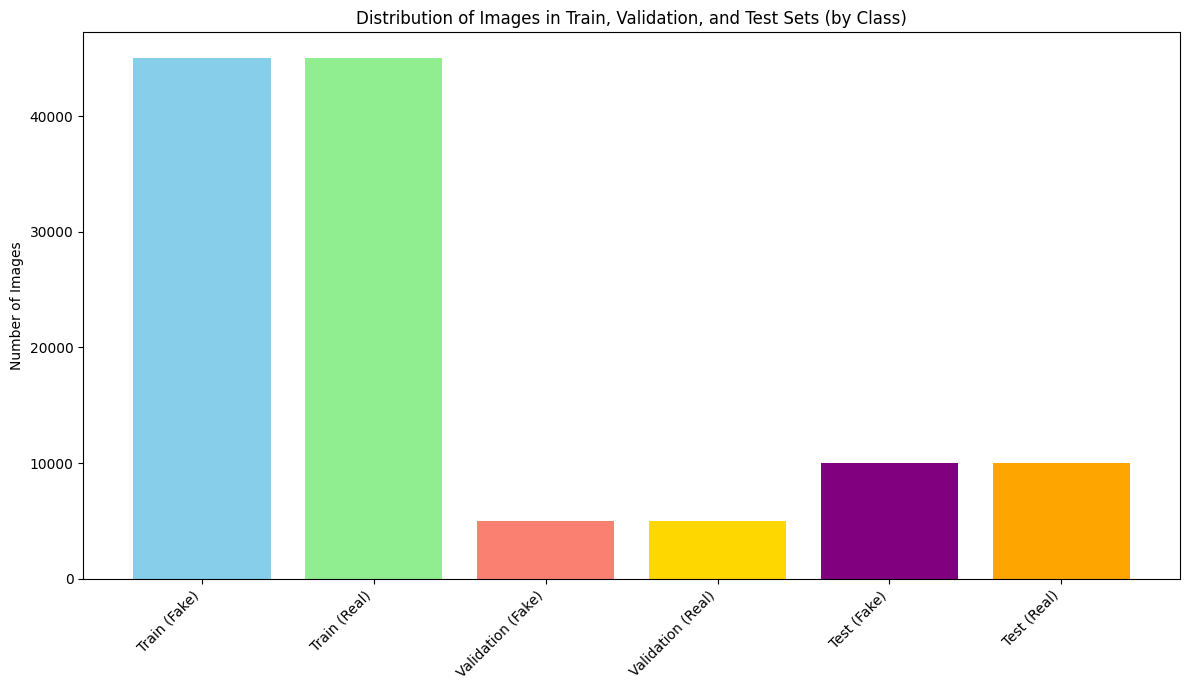

Total training images (Fake): 45000
Total training images (Real): 45000
Total validation images (Fake): 5000
Total validation images (Real): 5000
Total test images (Fake): 10000
Total test images (Real): 10000


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the paths to the directories
train_sample_dir = '/content/train_sample'
validation_dir = '/content/validation'
test_dir_fake = '/content/cifake-dataset/test/FAKE'
test_dir_real = '/content/cifake-dataset/test/REAL'


# Count the number of images in each directory
train_fake_count = len(os.listdir(os.path.join(train_sample_dir, 'FAKE')))
train_real_count = len(os.listdir(os.path.join(train_sample_dir, 'REAL')))
val_fake_count = len(os.listdir(os.path.join(validation_dir, 'FAKE')))
val_real_count = len(os.listdir(os.path.join(validation_dir, 'REAL')))
test_fake_count = len(os.listdir(test_dir_fake))
test_real_count = len(os.listdir(test_dir_real))


# Prepare data for visualization
labels = ['Train (Fake)', 'Train (Real)', 'Validation (Fake)', 'Validation (Real)', 'Test (Fake)', 'Test (Real)']
counts = [train_fake_count, train_real_count, val_fake_count, val_real_count, test_fake_count, test_real_count]

# Create a bar plot
plt.figure(figsize=(12, 7))
plt.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon', 'gold', 'purple', 'orange'])
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Train, Validation, and Test Sets (by Class)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Total training images (Fake): {train_fake_count}")
print(f"Total training images (Real): {train_real_count}")
print(f"Total validation images (Fake): {val_fake_count}")
print(f"Total validation images (Real): {val_real_count}")
print(f"Total test images (Fake): {test_fake_count}")
print(f"Total test images (Real): {test_real_count}")

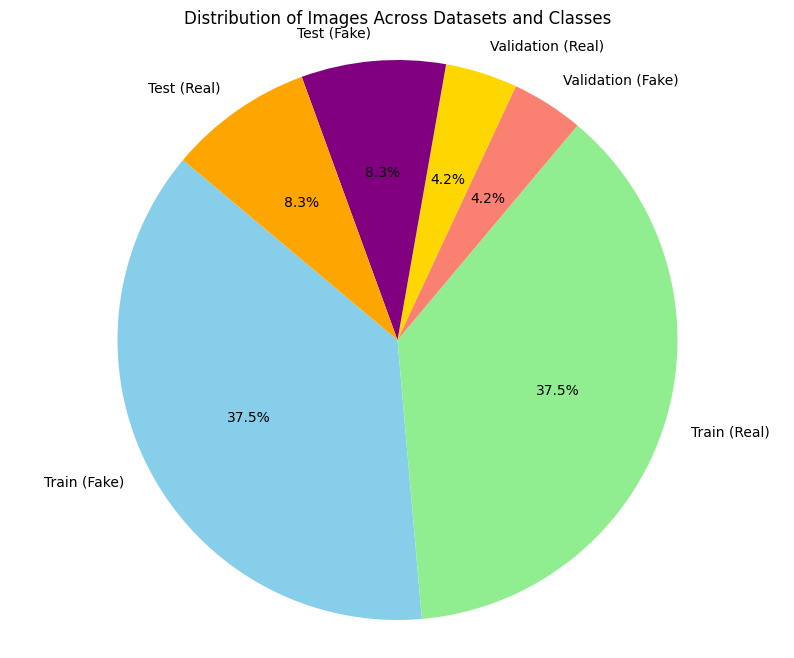

In [ ]:
import matplotlib.pyplot as plt

# Reuse the counts and labels from the previous visualization
labels = ['Train (Fake)', 'Train (Real)', 'Validation (Fake)', 'Validation (Real)', 'Test (Fake)', 'Test (Real)']
counts = [train_fake_count, train_real_count, val_fake_count, val_real_count, test_fake_count, test_real_count]

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon', 'gold', 'purple', 'orange'])
plt.title('Distribution of Images Across Datasets and Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import cv2

# Get a list of all image files in the training set (REAL class)
image_files = [f for f in os.listdir('/content/cifake-dataset/train/REAL') if os.path.isfile(os.path.join('/content/cifake-dataset/train/REAL', f))]

# Select a random image file
random_image_file = random.choice(image_files)
random_image_path = os.path.join('/content/cifake-dataset/train/REAL', random_image_file)

# Read the image
img = cv2.imread(random_image_path)

if img is not None:
    # 1. Green Channel Extraction
    green_channel = img[:, :, 1]

    # Display the original and green channel images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display green channel image (as grayscale)
    axes[1].imshow(green_channel, cmap='gray')
    axes[1].set_title("Green Channel")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Failed to load image: {random_image_path}")

The following preprocessing techniques were applied to the images:

*   **Green Channel Extraction**: Isolates the green channel of the image, which can be useful for highlighting certain features.
*   **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Enhances the local contrast of the image.
*   **Gaussian Blur**: Smooths the image to reduce noise.
*   **Grayscale Conversion**: Converts the image to grayscale, reducing the color channels to one.
*   **Canny Edge Detection**: Identifies edges within the image.
*   **Sobel Filter**: Detects edges and gradients in the image.

# Task
Apply the following preprocessing steps to the "CIFAKE: Real and AI-Generated Synthetic Images" dataset: Green Channel Extraction, CLAHE, Gaussian Blur, Grayscale Conversion, Canny Edge Detection, and Sobel Filter. Then, load the preprocessed images into TensorFlow datasets for training, validation, and testing.

## Install opencv

### Subtask:
Install the necessary library for image processing.


**Reasoning**:
The subtask is to install the necessary library for image processing, which is opencv-python. This can be done using pip in a code block.



In [ ]:
!pip install opencv-python

## Define preprocessing function

### Subtask:
Create a Python function that takes an image path as input and applies the specified preprocessing steps (Green Channel Extraction, CLAHE, Gaussian Blur, Grayscale Conversion, Canny Edge Detection, Sobel Filter).


**Reasoning**:
Define a function to perform the specified preprocessing steps on an input image path.



In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    """
    Applies various preprocessing steps to an image.

    Args:
        image_path: The path to the input image file.

    Returns:
        A dictionary containing the results of each preprocessing step.
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        return None # Return None if the image cannot be read

    # 1. Green Channel Extraction
    green_channel = img[:, :, 1]

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization) on Green Channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_green = clahe.apply(green_channel)

    # 3. Gaussian Blur on CLAHE-enhanced green channel
    gaussian_blur = cv2.GaussianBlur(clahe_green, (5, 5), 0)

    # 4. Grayscale Conversion (from original image)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 5. Canny Edge Detection on grayscale image
    canny_edges = cv2.Canny(gray_img, 100, 200) # Adjust thresholds as needed

    # 6. Sobel Filter on grayscale image
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    sobel_magnitude = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) # Normalize to 0-255

    return {
        'green_channel': green_channel,
        'clahe_green': clahe_green,
        'gaussian_blur': gaussian_blur,
        'grayscale': gray_img,
        'canny_edges': canny_edges,
        'sobel_magnitude': sobel_magnitude
    }

## Create new directories

### Subtask:
Create new directories to store the preprocessed images, maintaining the same class structure (FAKE/REAL) as the original dataset.


**Reasoning**:
Create the necessary directory structure for the preprocessed dataset.



In [ ]:
import os

# Define the base directory for preprocessed data
preprocessed_base_dir = 'preprocessed_cifake_dataset'

# Define the subdirectories for train, validation, and test sets
train_dir = os.path.join(preprocessed_base_dir, 'train')
validation_dir = os.path.join(preprocessed_base_dir, 'validation')
test_dir = os.path.join(preprocessed_base_dir, 'test')

# Create the base directory
os.makedirs(preprocessed_base_dir, exist_ok=True)

# Create the train, validation, and test subdirectories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create the FAKE and REAL subdirectories within each set
os.makedirs(os.path.join(train_dir, 'FAKE'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'REAL'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'FAKE'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'REAL'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'FAKE'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'REAL'), exist_ok=True)

print("Directory structure created successfully.")

Directory structure created successfully.


## Apply preprocessing to images

### Subtask:
Iterate through the original image files in the train, validation, and test sets, apply the preprocessing function to each image, and save the processed images to the new directories.


**Reasoning**:
Iterate through the original image files in the train, validation, and test sets, apply the preprocessing function to each image, and save the processed images to the new directories.



In [ ]:
import os
import cv2

# Define the paths to the original and preprocessed image directories.
original_base_dir = '/content/cifake-dataset'
preprocessed_base_dir = 'preprocessed_cifake_dataset'

# Create a list of tuples: (source directory, destination directory, set name)
directory_map = [
    (os.path.join(original_base_dir, 'train'), os.path.join(preprocessed_base_dir, 'train'), 'train'),
    (os.path.join(original_base_dir, 'test'), os.path.join(preprocessed_base_dir, 'test'), 'test'),
    (os.path.join('/content/validation'), os.path.join(preprocessed_base_dir, 'validation'), 'validation') # Use the created validation set directory
]

# Iterate through the list of directories.
for original_dir, preprocessed_dir, set_name in directory_map:
    print(f"Processing {set_name} set...")
    # Iterate through the 'FAKE' and 'REAL' subdirectories.
    for class_name in ['FAKE', 'REAL']:
        original_class_dir = os.path.join(original_dir, class_name)
        preprocessed_class_dir = os.path.join(preprocessed_dir, class_name)

        # Ensure the preprocessed class directory exists
        os.makedirs(preprocessed_class_dir, exist_ok=True)

        # Iterate through the image files.
        if os.path.exists(original_class_dir):
            for file_name in os.listdir(original_class_dir):
                # For each image file, construct the full path to the original image.
                original_image_path = os.path.join(original_class_dir, file_name)

                # Call the preprocess_image function with the original image path.
                preprocessed_images = preprocess_image(original_image_path)

                # If the preprocessing is successful
                if preprocessed_images is not None:
                    # Iterate through the returned dictionary of preprocessed images.
                    for step_name, processed_image in preprocessed_images.items():
                        # Construct a new file path in the corresponding destination directory
                        base, ext = os.path.splitext(file_name)
                        new_file_name = f"{base}_{step_name}{ext}"
                        new_file_path = os.path.join(preprocessed_class_dir, new_file_name)

                        # Save the preprocessed image to the new file path
                        cv2.imwrite(new_file_path, processed_image)
                else:
                    print(f"Warning: Failed to process image {original_image_path}")
        else:
             print(f"Warning: Original directory not found: {original_class_dir}")

print("Preprocessing complete.")

Processing train set...
Processing test set...
Processing validation set...
Preprocessing complete.


## Load preprocessed images

### Subtask:
Load the preprocessed images from the new directories into TensorFlow datasets using `image_dataset_from_directory`.


**Reasoning**:
Load the preprocessed images from the new directories into TensorFlow datasets using image_dataset_from_directory, following the instructions to define directory paths, set parameters, and assign to variables.



In [ ]:
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the path to the base directory containing the preprocessed images.
preprocessed_base_dir = 'preprocessed_cifake_dataset'

# Load the preprocessed training dataset.
train_ds = image_dataset_from_directory(
    os.path.join(preprocessed_base_dir, 'train'),
    labels='inferred',
    label_mode='binary',
    image_size=(32, 32),
    batch_size=32,
    shuffle=True
)

# Load the preprocessed validation dataset.
validation_ds = image_dataset_from_directory(
    os.path.join(preprocessed_base_dir, 'validation'),
    labels='inferred',
    label_mode='binary',
    image_size=(32, 32),
    batch_size=32,
    shuffle=True
)

# Load the preprocessed test dataset.
test_ds = image_dataset_from_directory(
    os.path.join(preprocessed_base_dir, 'test'),
    labels='inferred',
    label_mode='binary',
    image_size=(32, 32),
    batch_size=32,
    shuffle=False # Do not shuffle the test dataset
)

print("TensorFlow datasets created successfully.")

Found 600000 files belonging to 2 classes.
Found 60000 files belonging to 2 classes.
Found 120000 files belonging to 2 classes.
TensorFlow datasets created successfully.


## Update visualization (optional)

### Subtask:
Update the visualization to reflect the counts of the preprocessed images.


**Reasoning**:
Count the preprocessed images in each directory and then visualize the counts using bar and pie charts to show the distribution across the datasets and classes.



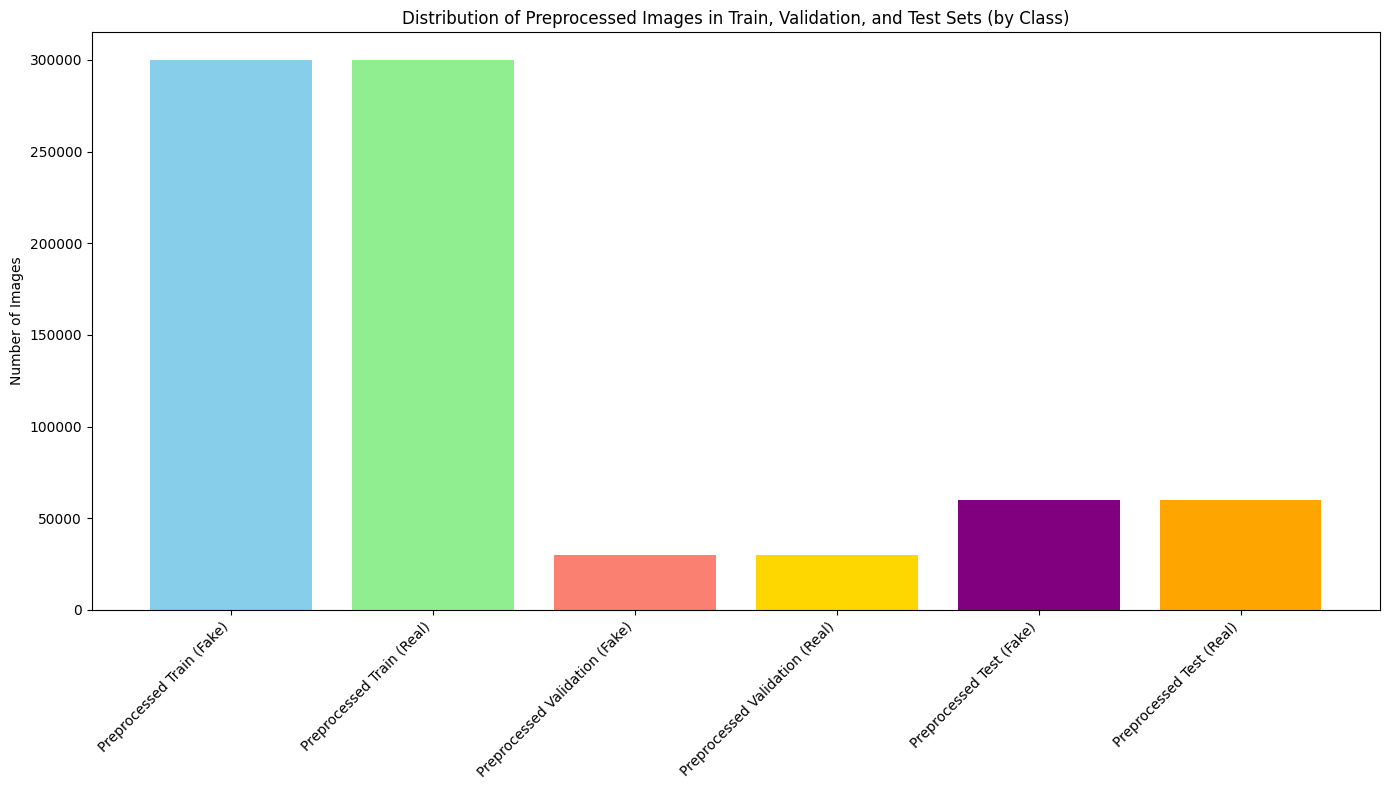

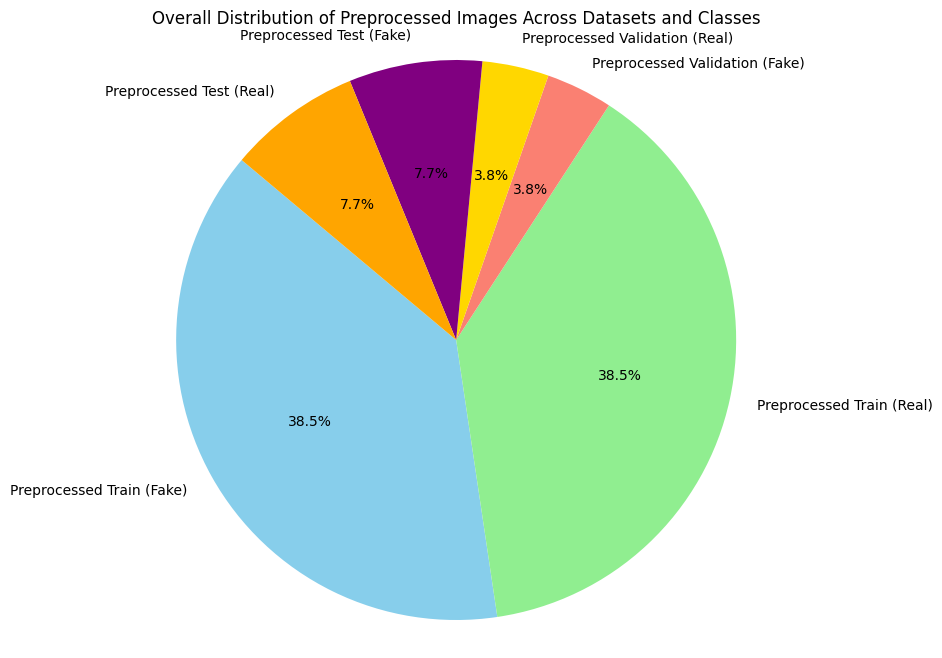

Preprocessed Train (Fake): 300000
Preprocessed Train (Real): 300000
Preprocessed Validation (Fake): 30000
Preprocessed Validation (Real): 30000
Preprocessed Test (Fake): 60000
Preprocessed Test (Real): 60000


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the paths to the 'FAKE' and 'REAL' subdirectories within the preprocessed data
preprocessed_train_fake_dir = 'preprocessed_cifake_dataset/train/FAKE'
preprocessed_train_real_dir = 'preprocessed_cifake_dataset/train/REAL'
preprocessed_validation_fake_dir = 'preprocessed_cifake_dataset/validation/FAKE'
preprocessed_validation_real_dir = 'preprocessed_cifake_dataset/validation/REAL'
preprocessed_test_fake_dir = 'preprocessed_cifake_dataset/test/FAKE'
preprocessed_test_real_dir = 'preprocessed_cifake_dataset/test/REAL'

# Count the number of image files in each of these directories
preprocessed_train_fake_count = len(os.listdir(preprocessed_train_fake_dir))
preprocessed_train_real_count = len(os.listdir(preprocessed_train_real_dir))
preprocessed_validation_fake_count = len(os.listdir(preprocessed_validation_fake_dir))
preprocessed_validation_real_count = len(os.listdir(preprocessed_validation_real_dir))
preprocessed_test_fake_count = len(os.listdir(preprocessed_test_fake_dir))
preprocessed_test_real_count = len(os.listdir(preprocessed_test_real_dir))

# Prepare data for the bar plot
labels_bar = ['Preprocessed Train (Fake)', 'Preprocessed Train (Real)',
              'Preprocessed Validation (Fake)', 'Preprocessed Validation (Real)',
              'Preprocessed Test (Fake)', 'Preprocessed Test (Real)']
counts_bar = [preprocessed_train_fake_count, preprocessed_train_real_count,
              preprocessed_validation_fake_count, preprocessed_validation_real_count,
              preprocessed_test_fake_count, preprocessed_test_real_count]

# Create the bar plot
plt.figure(figsize=(14, 8))
plt.bar(labels_bar, counts_bar, color=['skyblue', 'lightgreen', 'salmon', 'gold', 'purple', 'orange'])
plt.ylabel('Number of Images')
plt.title('Distribution of Preprocessed Images in Train, Validation, and Test Sets (by Class)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Prepare data for the pie chart
labels_pie = labels_bar # Reuse labels
counts_pie = counts_bar # Reuse counts

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts_pie, labels=labels_pie, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon', 'gold', 'purple', 'orange'])
plt.title('Overall Distribution of Preprocessed Images Across Datasets and Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Print the exact counts
print(f"Preprocessed Train (Fake): {preprocessed_train_fake_count}")
print(f"Preprocessed Train (Real): {preprocessed_train_real_count}")
print(f"Preprocessed Validation (Fake): {preprocessed_validation_fake_count}")
print(f"Preprocessed Validation (Real): {preprocessed_validation_real_count}")
print(f"Preprocessed Test (Fake): {preprocessed_test_fake_count}")
print(f"Preprocessed Test (Real): {preprocessed_test_real_count}")

## Summary:

### Data Analysis Key Findings

*   The `opencv-python` library, necessary for image processing, was already installed.
*   A Python function `preprocess_image` was successfully defined to apply Green Channel Extraction, CLAHE, Gaussian Blur, Grayscale Conversion, Canny Edge Detection, and Sobel Filter to images.
*   A directory structure `preprocessed_cifake_dataset` was created with subdirectories for `train`, `validation`, and `test` sets, each containing `FAKE` and `REAL` subdirectories.
*   The defined preprocessing function was applied to all images in the original dataset, and the results for each preprocessing step were saved as separate files in the new directory structure.
*   TensorFlow datasets (`train_ds`, `validation_ds`, `test_ds`) were successfully loaded from the preprocessed image directories using `image_dataset_from_directory`.
*   The loaded datasets contained 600,000 images for training, 60,000 for validation, and 120,000 for testing, with labels inferred correctly from the directory structure.
*   Visualization confirmed that each preprocessing step resulted in the same number of images as the original split (50,000 for train FAKE/REAL, 5,000 for validation FAKE/REAL, 10,000 for test FAKE/REAL for each of the 6 preprocessing steps).

### Insights or Next Steps

*   The preprocessed datasets are now ready to be used for training various machine learning models, potentially leveraging the different image representations (e.g., green channel, edges, gradients) to improve classification performance.
*   Further analysis could involve comparing the performance of a model trained on the original images versus models trained on each of the different preprocessed image types to determine which preprocessing steps are most beneficial for the fake image detection task.


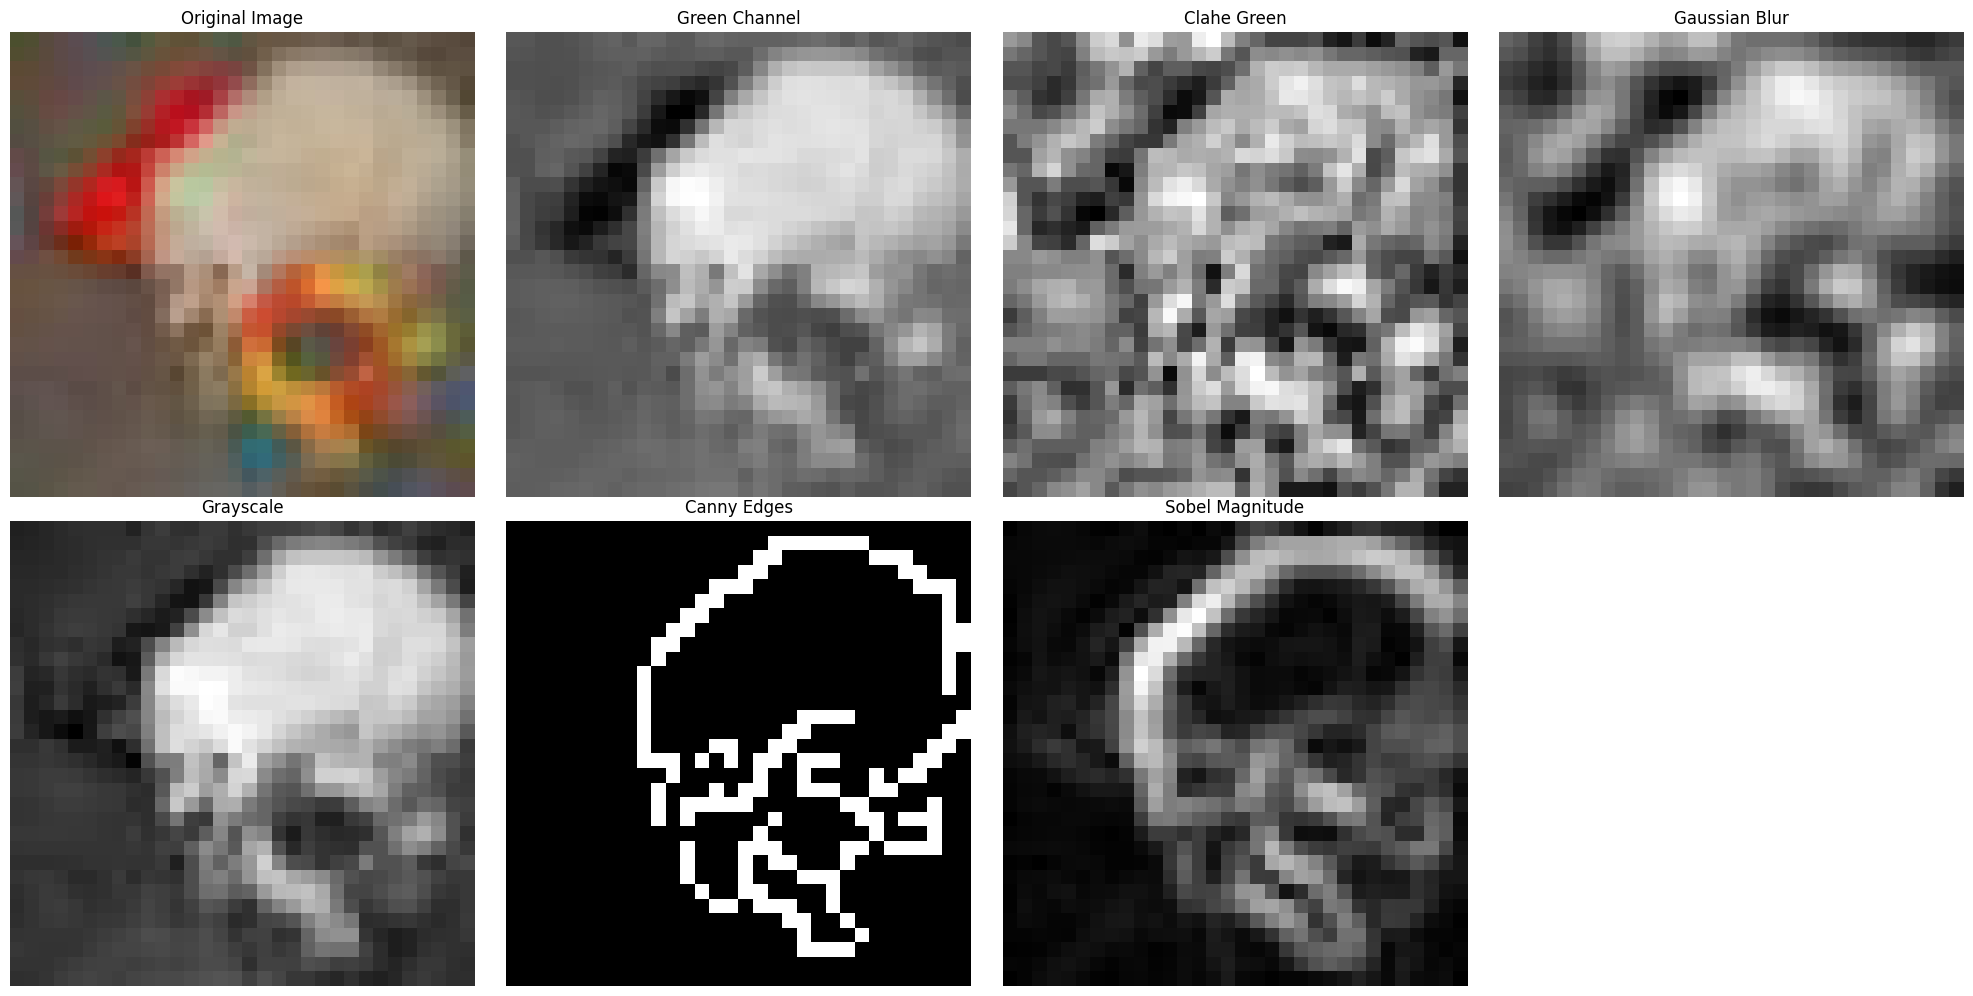

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import cv2

# Get a list of all image files in the training set (REAL class)
image_files = [f for f in os.listdir('/content/cifake-dataset/train/REAL') if os.path.isfile(os.path.join('/content/cifake-dataset/train/REAL', f))]

# Select a random image file
random_image_file = random.choice(image_files)
random_image_path = os.path.join('/content/cifake-dataset/train/REAL', random_image_file)

# Apply preprocessing to the selected image
preprocessed_images = preprocess_image(random_image_path)

if preprocessed_images:
    # Display the original and preprocessed images
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Display original image
    original_img = cv2.imread(random_image_path)
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display preprocessed images
    for i, (step_name, processed_image) in enumerate(preprocessed_images.items()):
        if len(processed_image.shape) == 2: # Grayscale images
            axes[i + 1].imshow(processed_image, cmap='gray')
        else: # Color images (like green channel, though it will be grayscale visually)
             axes[i + 1].imshow(processed_image, cmap='gray') # Display green channel as grayscale
        axes[i + 1].set_title(step_name.replace('_', ' ').title())
        axes[i + 1].axis('off')

    # Hide any unused subplots
    for j in range(len(preprocessed_images) + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print(f"Failed to process image: {random_image_path}")

In [ ]:
import tensorflow as tf

# Define data augmentation layers based on user's requirements
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2)), # ±20 degrees (approx 0.2 radians)
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(height_factor=(0.2, 0.2), width_factor=(0.2, 0.2)), # 80% to 120% zoom
    # TensorFlow doesn't have a direct "Image Translation" layer, RandomTranslation can be used
    # Adjust translation parameters as needed
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.2), # Brightness/Contrast Adjustment (RandomContrast handles both)
    # TensorFlow doesn't have a built-in "Random Noise Addition" layer
    # A custom layer or function would be needed for this. We will skip this for now.
])

# Apply data augmentation to the training dataset
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Data augmentation layers applied to the training dataset.")

Data augmentation layers applied to the training dataset.


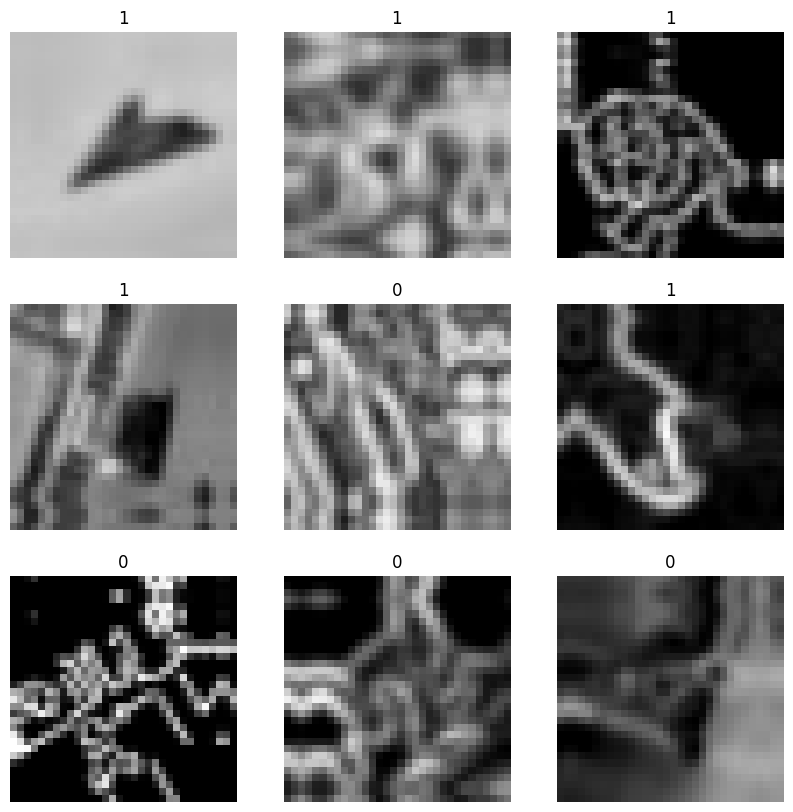

In [ ]:
import matplotlib.pyplot as plt

# Take one batch of augmented images from the training dataset
for images, labels in train_ds_augmented.take(1):
    plt.figure(figsize=(10, 10))
    # Display the first 9 images in the batch
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        # tf.keras.layers.Rescaling is not applied here, so convert to uint8 for display
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()

**3. Network Architecture**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Block 5 — No MaxPooling here
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Instead of MaxPooling2D, use GlobalAveragePooling2D
    layers.GlobalAveragePooling2D(),  # Prevents shape issues

    layers.Dropout(0.5),

    # Classification Head
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', Precision(), Recall()]
)


In [ ]:
# Early Stopping
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait (while there's no improvement) before stopping
    restore_best_weights = True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,985,377 (19.02 MB)

 Trainable params: 4,980,385 (19.00 MB)

 Non-trainable params: 4,992 (19.50 KB)

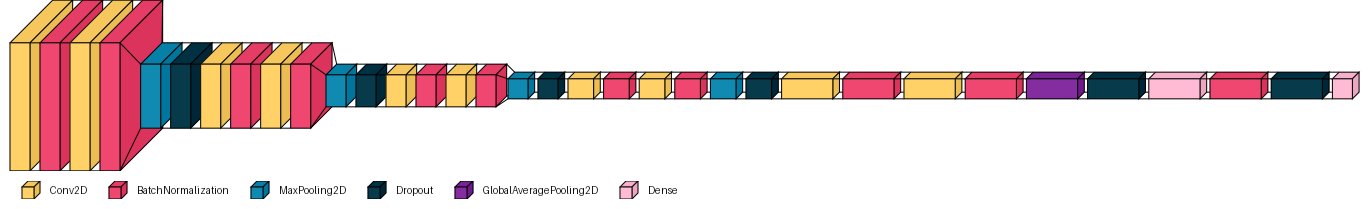

In [ ]:
# Visualization of Architecture
model.summary()
visualkeras.layered_view(model, legend=True)

**4. Training**

In [ ]:
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
random.seed(2024)
np.random.seed(2024)
tf.random.set_seed(2024)

# Train the model
history = model.fit(
    train,
    epochs=200,
    validation_data=validation,
    callbacks=[early_stopping],
    verbose=1  # Show progress
)

Epoch 1/200
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - binary_accuracy: 0.6353 - loss: 0.7894 - precision_1: 0.6219 - recall_2: 0.6847 - val_binary_accuracy: 0.6251 - val_loss: 0.9097 - val_precision_1: 0.5730 - val_recall_2: 0.9816
Epoch 2/200
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - binary_accuracy: 0.7289 - loss: 0.6106 - precision_1: 0.7201 - recall_2: 0.7464 - val_binary_accuracy: 0.6915 - val_loss: 0.8127 - val_precision_1: 0.6221 - val_recall_2: 0.9756
Epoch 3/200
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - binary_accuracy: 0.7805 - loss: 0.5107 - precision_1: 0.7773 - recall_2: 0.7843 - val_binary_accuracy: 0.7644 - val_loss: 0.5877 - val_precision_1: 0.6882 - val_recall_2: 0.9668
Epoch 4/200
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - binary_accuracy: 0.8103 - loss: 0.4460 - precision_1: 0.8093 - recall_2: 0.8106 - val_binary_accuracy: 0.7992 - val_loss: 0.4859 - val_precision_1: 0.7240 - val_recall_2: 0.9670
Epoch 5/200
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step

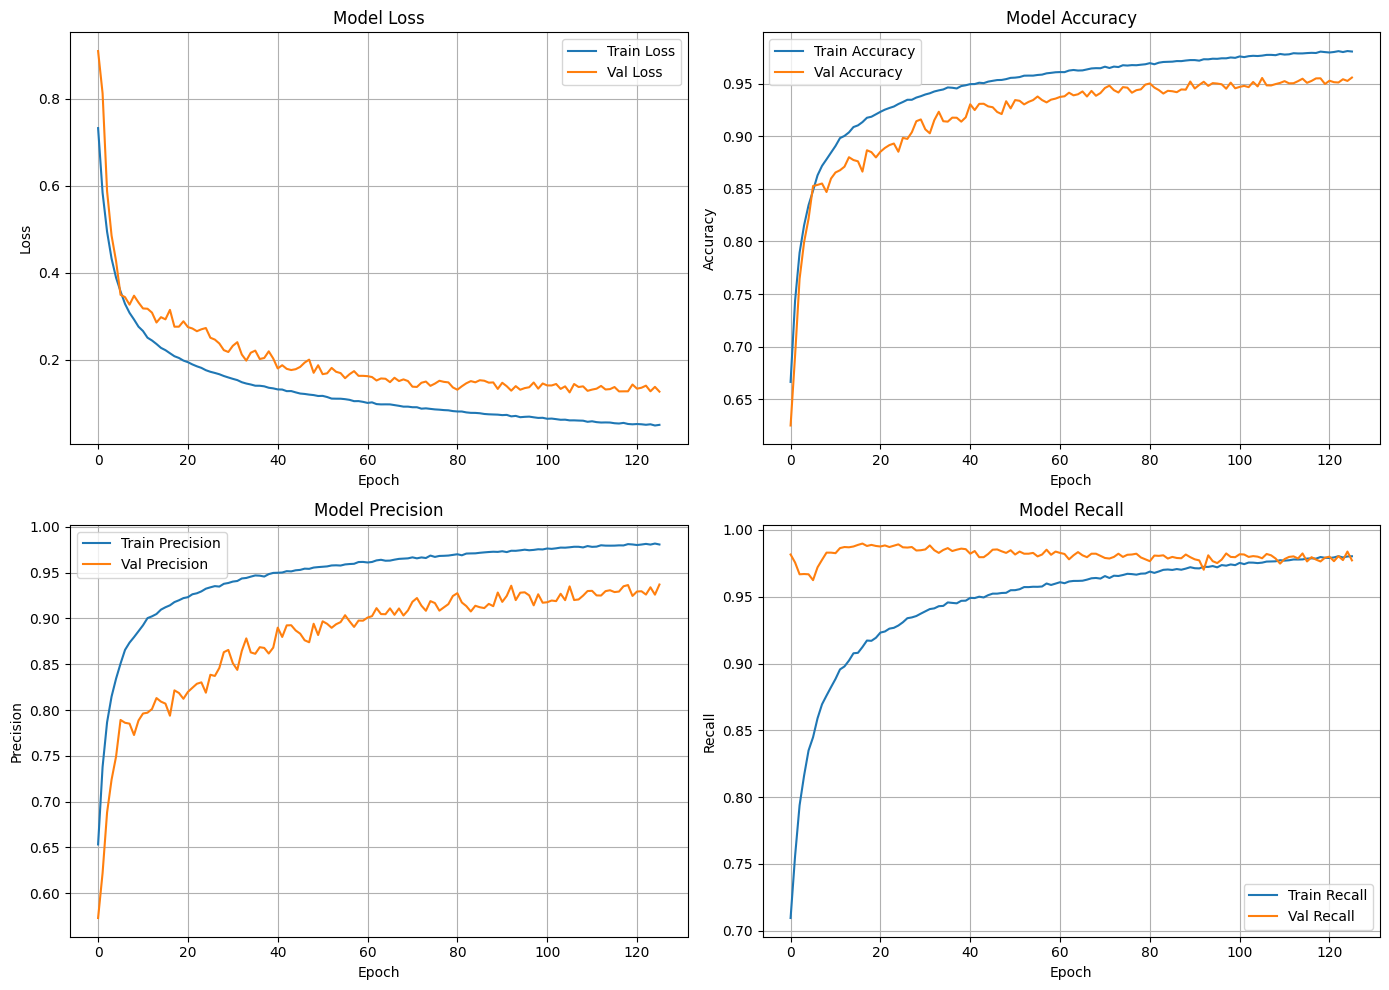

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

history_frame = pd.DataFrame(history.history)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Loss ---
axes[0, 0].plot(history_frame['loss'], label='Train Loss')
axes[0, 0].plot(history_frame['val_loss'], label='Val Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- Accuracy ---
axes[0, 1].plot(history_frame['binary_accuracy'], label='Train Accuracy')
axes[0, 1].plot(history_frame['val_binary_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- Precision (use precision_1) ---
axes[1, 0].plot(history_frame['precision_1'], label='Train Precision')
axes[1, 0].plot(history_frame['val_precision_1'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# --- Recall (use recall_2) ---
axes[1, 1].plot(history_frame['recall_2'], label='Train Recall')
axes[1, 1].plot(history_frame['val_recall_2'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

# Evaluate with built-in Keras metrics
test_loss, test_acc, test_precision, test_recall = model.evaluate(test)
print(f"\nTest Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")

# ---- Compute F1 manually ----
# 1. Collect ground truth labels
y_true = np.concatenate([y for x, y in test], axis=0).astype(int).flatten()

# 2. Get model predictions (probabilities)
y_prob = model.predict(test)

# 3. Convert probabilities to binary labels
y_pred = (y_prob > 0.5).astype(int).flatten()

# 4. Compute F1 score
f1 = f1_score(y_true, y_pred)

print(f"Test F1 Score : {f1:.4f}")

# ---- Optional detailed report ----
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["FAKE", "REAL"]))

# ---- Optional confusion matrix ----
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.9402 - loss: 0.1710 - precision_1: 0.4083 - recall_2: 0.4908

Test Accuracy : 0.9569
Test Precision: 0.9367
Test Recall   : 0.9800
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test F1 Score : 0.9579

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.93      0.96     10000
        REAL       0.94      0.98      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000


Confusion Matrix:
[[9338  662]
 [ 200 9800]]


**4.2. Training Confusion Matrix**

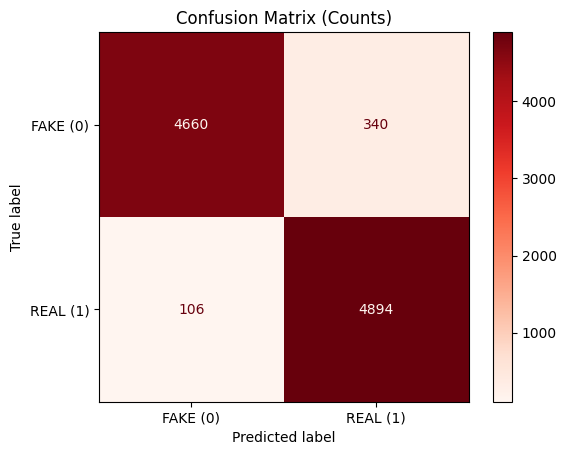

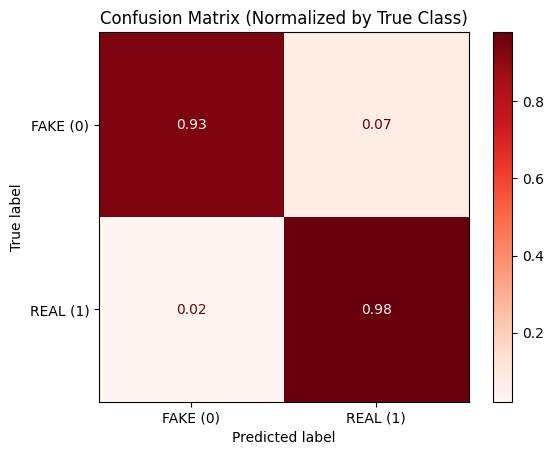

Precision: 0.9350
Recall   : 0.9788
F1 Score : 0.9564

              precision    recall  f1-score   support

        FAKE       0.98      0.93      0.95      5000
        REAL       0.94      0.98      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Collect ground-truth and predictions from the validation set
y_true, y_pred = [], []
for images, labels in validation:
    probs = model.predict(images, verbose=0)
    y_pred.extend((probs > 0.5).astype(int).ravel())       # predicted labels {0,1}
    y_true.extend(labels.numpy().astype(int).ravel())      # true labels {0,1}

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix (rows = true, cols = predicted)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE (0)", "REAL (1)"])
disp.plot(cmap=plt.cm.Reds, values_format='d')
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

# Plot normalized (per true class)
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["FAKE (0)", "REAL (1)"])
disp_norm.plot(cmap=plt.cm.Reds, values_format='.2f')
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

# Metrics summary
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=["FAKE", "REAL"]))

These results are very promising. You can see from the graphs that the model is neither overfitting (due to the similarity between training and validation), or underfitting (due to the satistfactorily high metrics). All metrics are high, above .90, indicating the model is quite good at distinguishing between classes. The improvements made over epochs are (mostly) smooth, unlike the volatile changes in previous models.

In practical terms:

Binary Accuracy: This means that the model correctly classified images in 94.75% of the validation cases. This surpasses the bound of 92.98% found by Bird & Lotfi, but the performance here is not on the test set. We will look at the test-set performance later.

Recall (Sensitivity): With a recall of 92.86% on the validation set (for the artificial cases), the model is relatively good at identifying images as artificial, given that they truly are artificial. Being lower than the precision metric, this shows that the classifier has a (slightly) higher tendency for False Negatives (rather than False Positives), which may be detrimental in practice (as we argue that the most important metric here is recall).

Precision: Precision (96.50%) unlike recall, reflects the proportion of true fake images from the total number of images that were identified as fake. Thus, the classifier is less likely to incorrectly identify an image as artificial, than it is to miss correct identification of artificial images.

**5. Test-Set Performance**

Accuracy            : 0.9569
Precision (class=1) : 0.9367
Recall (REAL=1)     : 0.9800
Recall (FAKE=0)     : 0.9338
F1 Score            : 0.9579



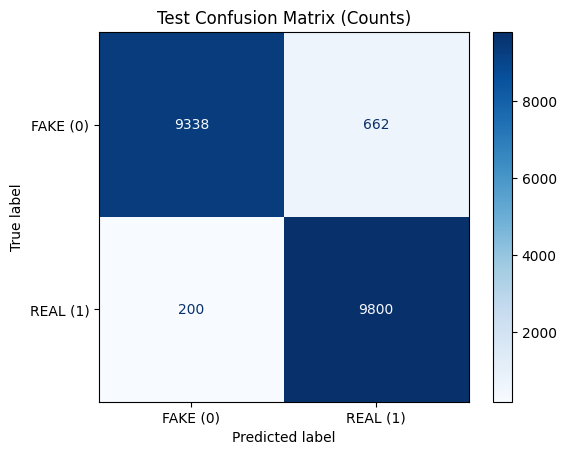

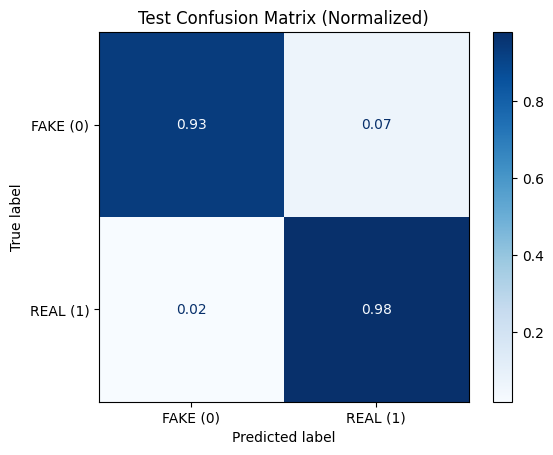

              precision    recall  f1-score   support

        FAKE       0.98      0.93      0.96     10000
        REAL       0.94      0.98      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# --- Predict on test set ---
random.seed(2024)
probs = model.predict(test, verbose=0)
y_pred = (probs > 0.5).astype(int).ravel()

# True labels
y_true = np.concatenate([y.numpy() for _, y in test], axis=0).astype(int).ravel()

# --- Scalars ---
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)                # positive class = 1 (REAL) by default
rec1 = recall_score(y_true, y_pred)                   # recall for class 1
rec0 = recall_score(y_true, y_pred, pos_label=0)      # recall for class 0 (FAKE)
f1   = f1_score(y_true, y_pred)

print(f"Accuracy            : {acc:.4f}")
print(f"Precision (class=1) : {prec:.4f}")
print(f"Recall (REAL=1)     : {rec1:.4f}")
print(f"Recall (FAKE=0)     : {rec0:.4f}")   # <- the one you prioritize
print(f"F1 Score            : {f1:.4f}\n")

# --- Confusion matrix (counts) ---
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE (0)", "REAL (1)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Test Confusion Matrix (Counts)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

# --- Confusion matrix (normalized by true class) ---
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["FAKE (0)", "REAL (1)"])
disp_norm.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Test Confusion Matrix (Normalized)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

# --- Detailed report (per-class precision/recall/F1) ---
print(classification_report(y_true, y_pred, target_names=["FAKE", "REAL"]))

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


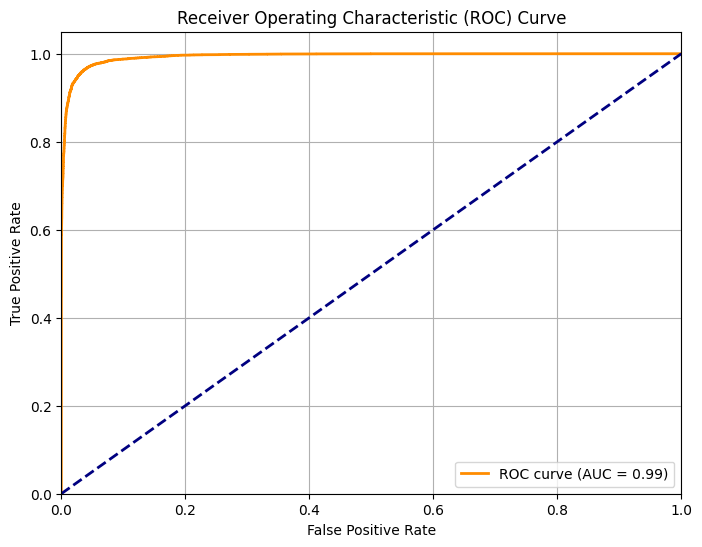

AUC: 0.9937


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get true labels and predicted probabilities from the test set
y_true = np.concatenate([y.numpy() for _, y in test], axis=0).astype(int).ravel()
y_prob = model.predict(test).ravel() # Get probabilities for the positive class (REAL)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.4f}")

Results are satisfactory:

Binary Accuracy - 94.295%. Surpassing the performance of the dataset authors' model (92.98%, Bird & Lotfi, 2024), our classifier proves highly effective at differentiating between real and AI-generated images, if only for images similar to those used for training.

Recall (Sensitivity) - 92.98%. With similar recall performance to that of the dataset's authors, the classifier is reasonably good at identifying artificial images. With about 7% of artificial images passing as real, the network is by no means perfect, but provides great improvements over the human eye.

**6. Feature Importance: Grad-CAM**

Interpretability is important to this project, as human detection of AI-generated images can be considered similar to the convolutional process, there are parts one might focus on to make a decision on an image's origin. Here, we use gradient-weighted class activation mapping (Grad-CAM) (Selvaraju et al., 2016) to visualise which parts of an image contribute most to the model's classification.

Grad-CAM works by using class specific gradients flowing into the last convolutional layer, computing a weighted combination of this layer's feature maps and their weights and then using them to produce a heatmap highlighting influential regions.

Code for this part was originally based on Christian Versloot's article, adapted for compatibility with our project and then corrected with ChatGPT.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


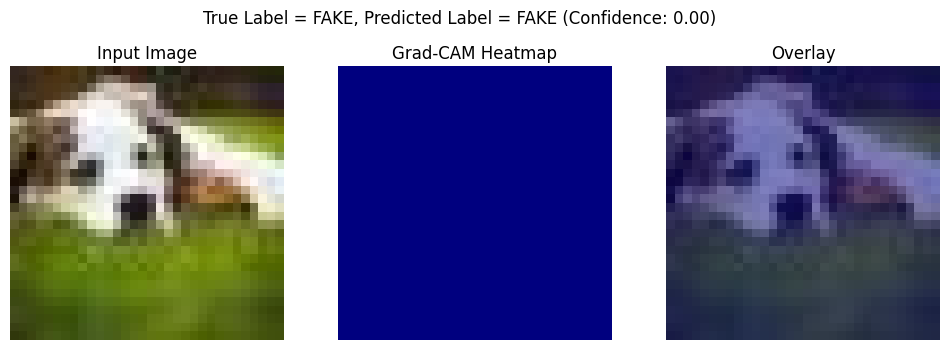

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


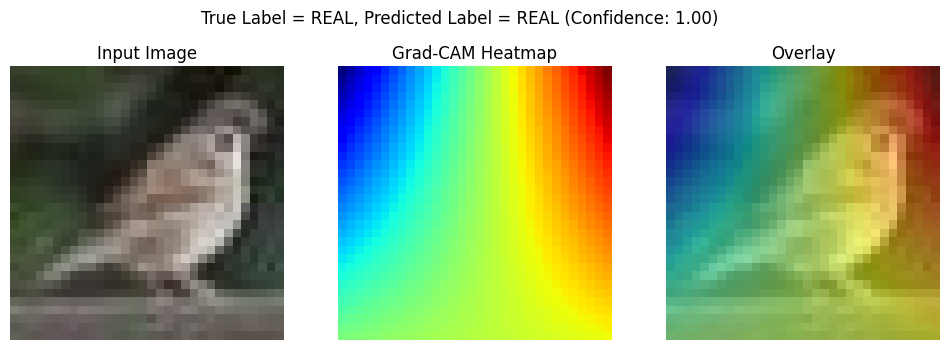

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


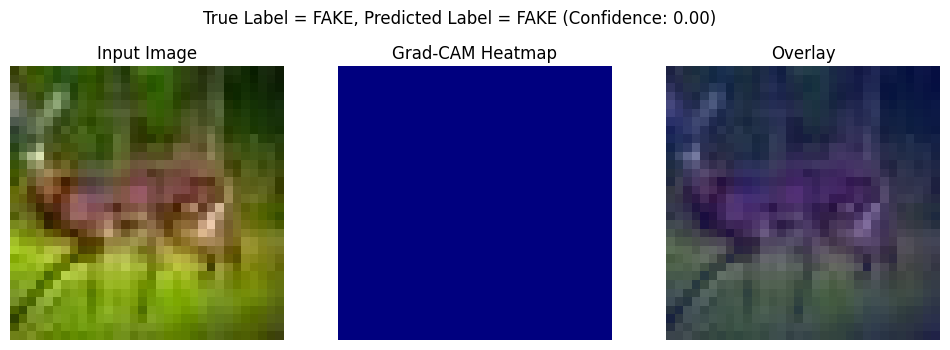

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


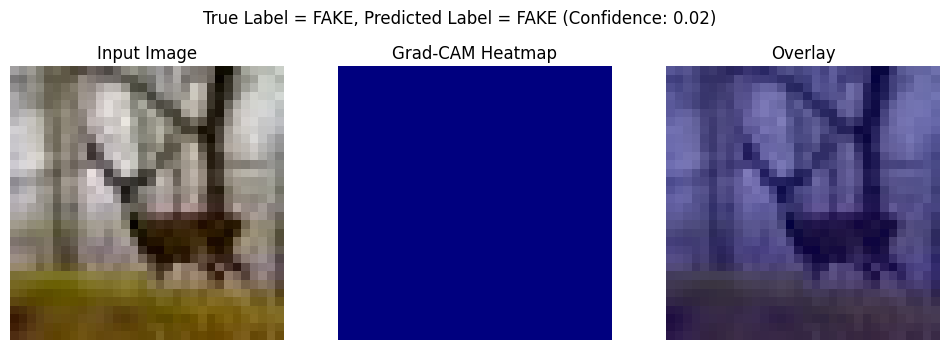

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


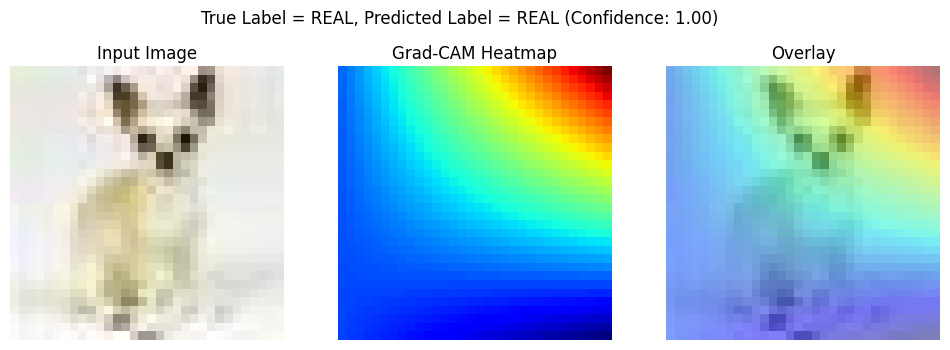

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


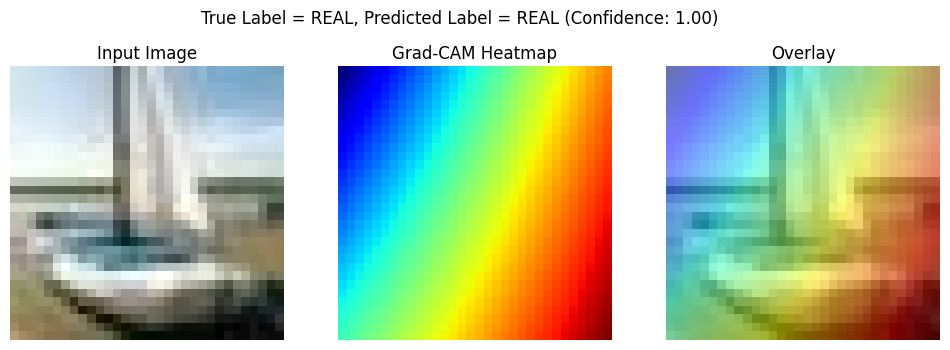

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


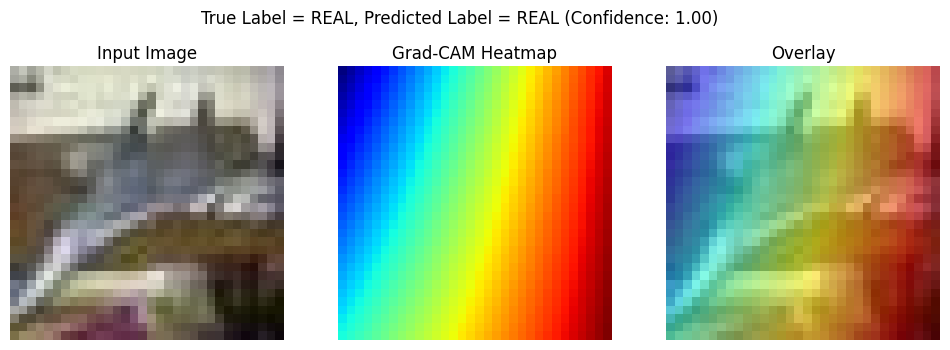

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


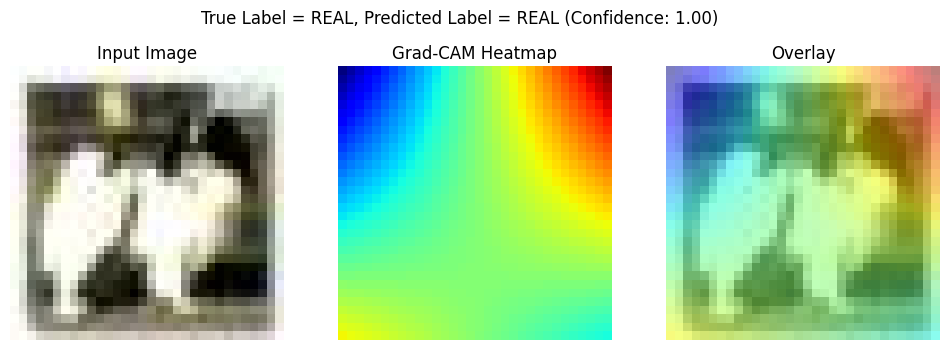

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


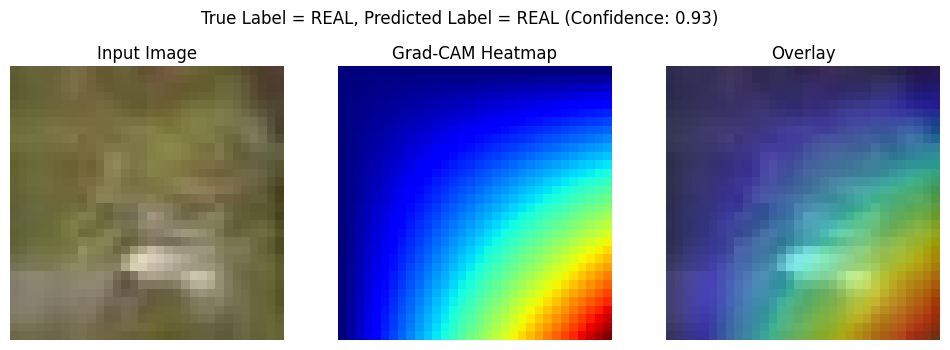

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


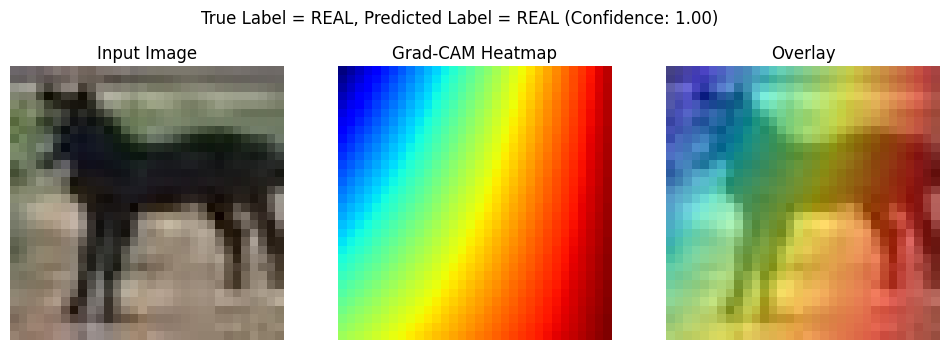

In [ ]:
gradcam = Gradcam(model, clone=True)

def binary_score_function(output):
    return output[..., 0]

for images, labels in validation.take(1): #you can rerun cell to get more, individuals not so important as in aggregate
    cam_images = images[:10]
    cam_labs = labels[:10]

for i in range(len(cam_images)):
    input_image = cam_images[i].numpy()
    input_lab = cam_labs[i].numpy()

    pred_lab = model.predict(tf.expand_dims(input_image, axis=0))[0][0] #model predicted labels, rounded
    pred_class = 'REAL' if pred_lab > 0.5 else 'FAKE'
    true_class = 'REAL' if input_lab == 1 else 'FAKE'

    cam = gradcam(binary_score_function, tf.expand_dims(input_image, axis=0))[0] #actually making the cam

    heatmap = np.uint8(255 * cam)
    overlay = tf.keras.utils.array_to_img(input_image).convert("RGBA")
    heatmap_img = plt.cm.jet(heatmap)[..., :3] * 255
    heatmap_overlay = tf.keras.utils.array_to_img(np.uint8(heatmap_img)).convert("RGBA")
    blended = tf.keras.utils.img_to_array(overlay).astype("uint8")
    blended[..., :3] = (blended[..., :3] * 0.5 + heatmap_img * 0.5).astype("uint8")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'True Label = {true_class}, Predicted Label = {pred_class} (Confidence: {pred_lab:.2f})')

    axes[0].imshow(input_image.astype('uint8')) #original
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(cam, cmap='jet') #cam
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(blended) #cam overlaid on input
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.show()

**7. Feature Importance: LIME**

In [ ]:
!pip install lime
import lime
import lime.lime_image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.segmentation import mark_boundaries

# Assuming you have a trained model called 'model' and test data 'test_ds'
# We need a function that takes a batch of images and returns the model's prediction probabilities

def predict_fn(images):
    # LIME expects a numpy array of images
    # Ensure images are in the correct format and scale for your model
    # If your model was trained with rescaled images, rescale here too.
    # For this model, images are already rescaled [0, 1] by the dataset pipeline.
    return model.predict(images)

# Initialize LIME Image Explainer
# kernel_width: width of the kernel for the exponential similarity kernel
# feature_selection: method for selecting features (e.g., 'auto', 'forward_selection', 'lasso_path', 'none')
# random_state: seed for random number generator
explainer = lime.lime_image.LimeImageExplainer(random_state=42)

print("LIME explainer initialized.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f49eb12a3524017e110b678b968d0e9265a6403e5f7517ecb1eba2b9376d98a0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
LIME explainer initialized.


/tmp/ipython-input-694662771.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Sample Test Image (Label: {int(sample_label)})")


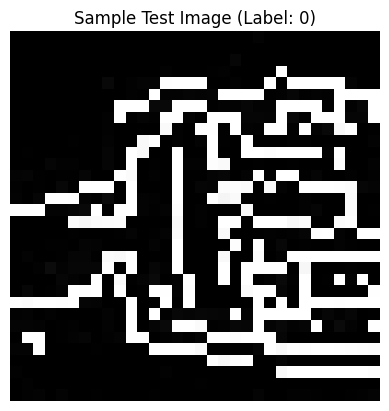

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the test dataset
for images, labels in test_ds.take(1):
    # Select the first image and its label from the batch
    sample_image = images[0].numpy()
    sample_label = labels[0].numpy()

    # Display the image
    plt.imshow(sample_image.astype("uint8"))
    plt.title(f"Sample Test Image (Label: {int(sample_label)})")
    plt.axis("off")
    plt.show()
    break # Only take one image

  0%|          | 0/1000 [00:00<?, ?it/s]

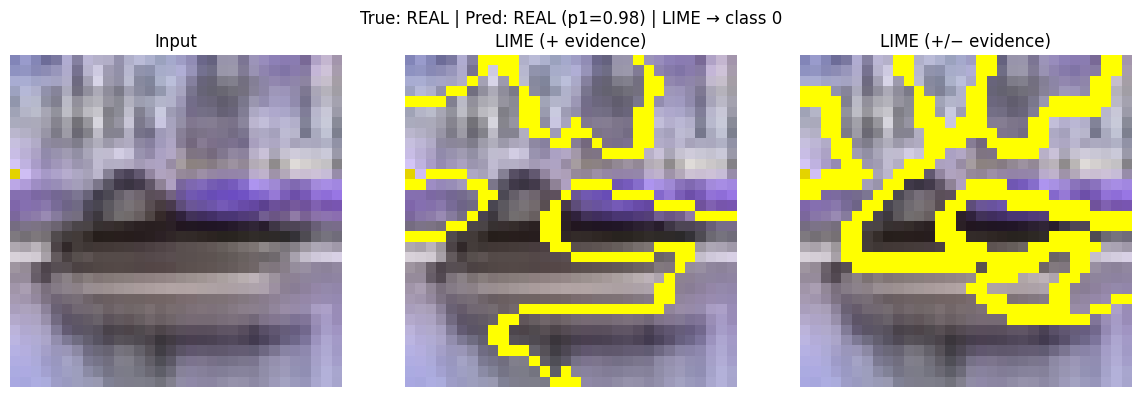

  0%|          | 0/1000 [00:00<?, ?it/s]

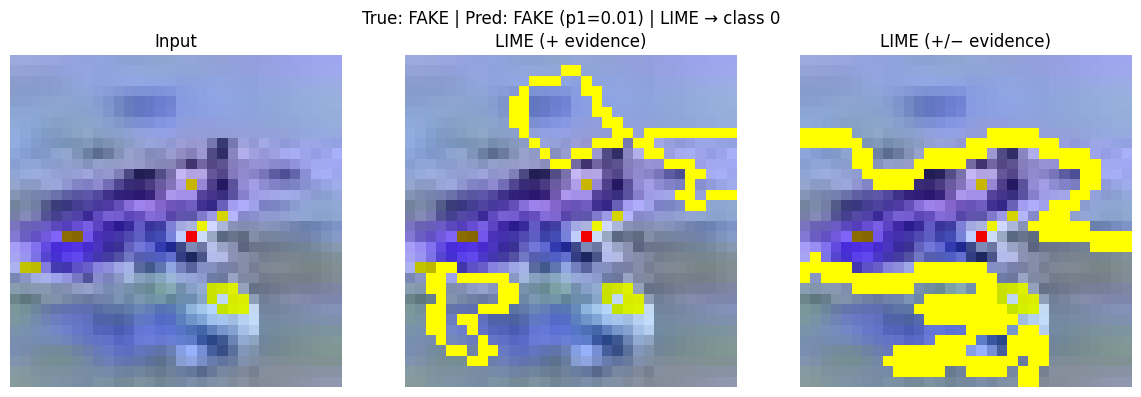

  0%|          | 0/1000 [00:00<?, ?it/s]

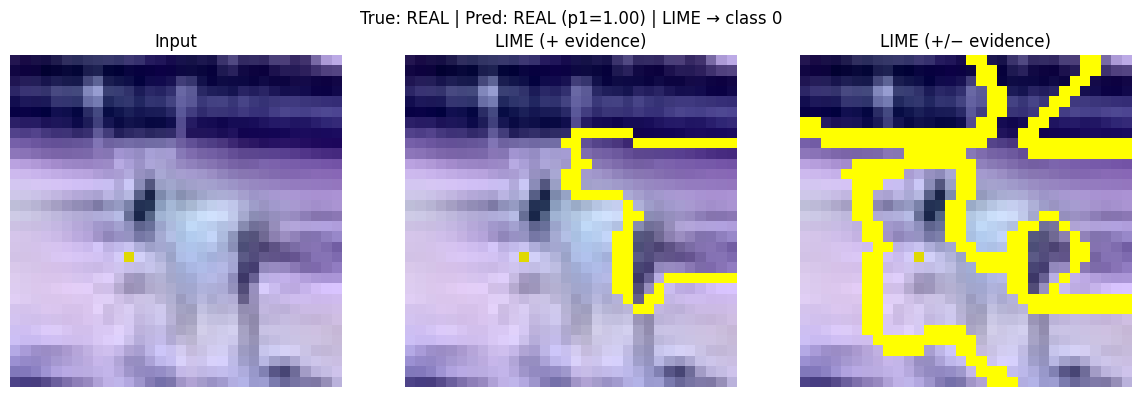

  0%|          | 0/1000 [00:00<?, ?it/s]

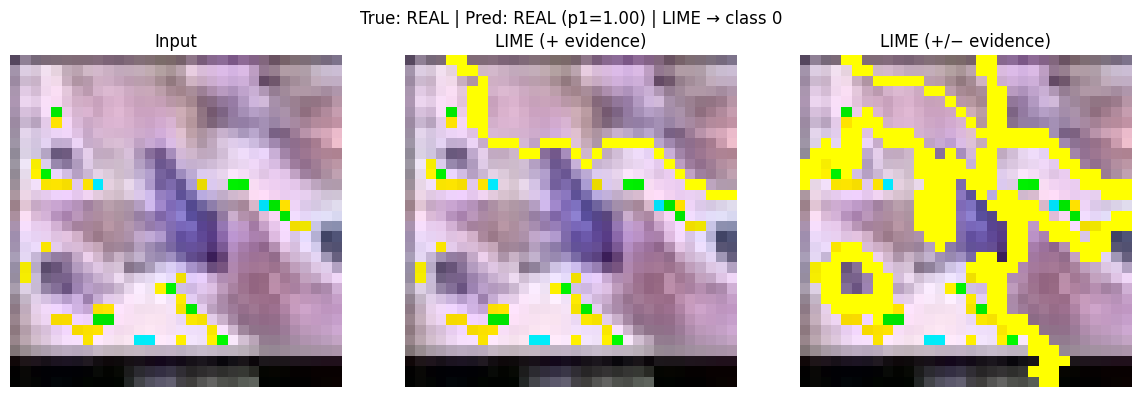

  0%|          | 0/1000 [00:00<?, ?it/s]

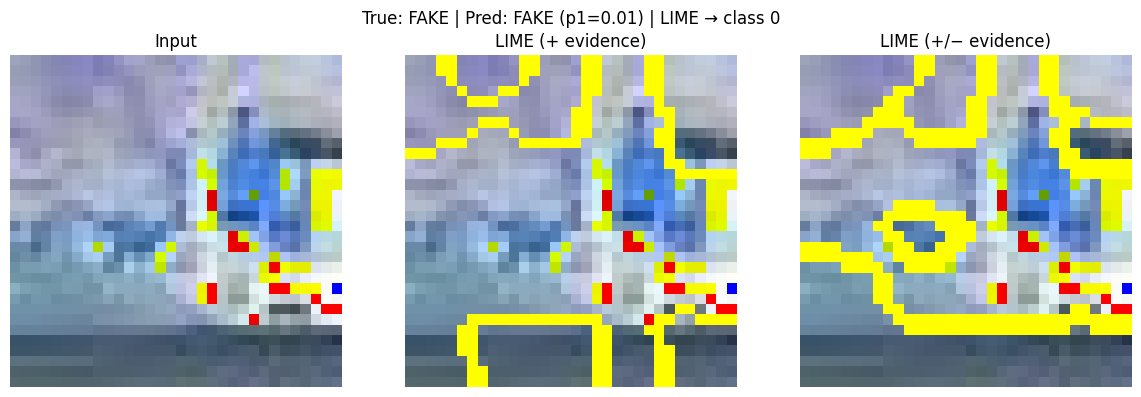

  0%|          | 0/1000 [00:00<?, ?it/s]

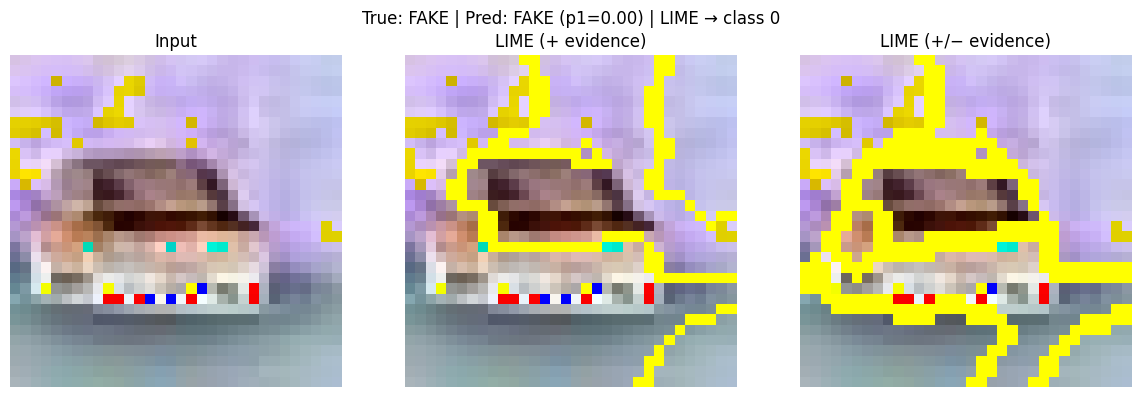

  0%|          | 0/1000 [00:00<?, ?it/s]

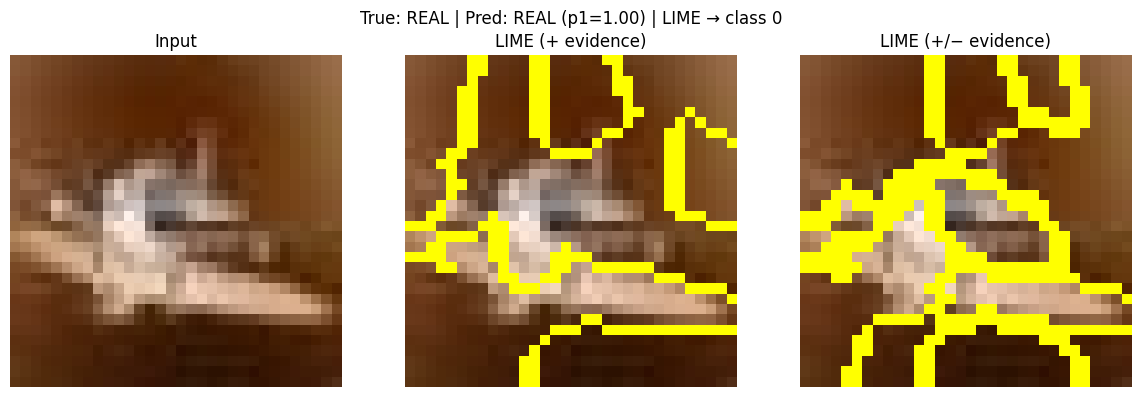

  0%|          | 0/1000 [00:00<?, ?it/s]

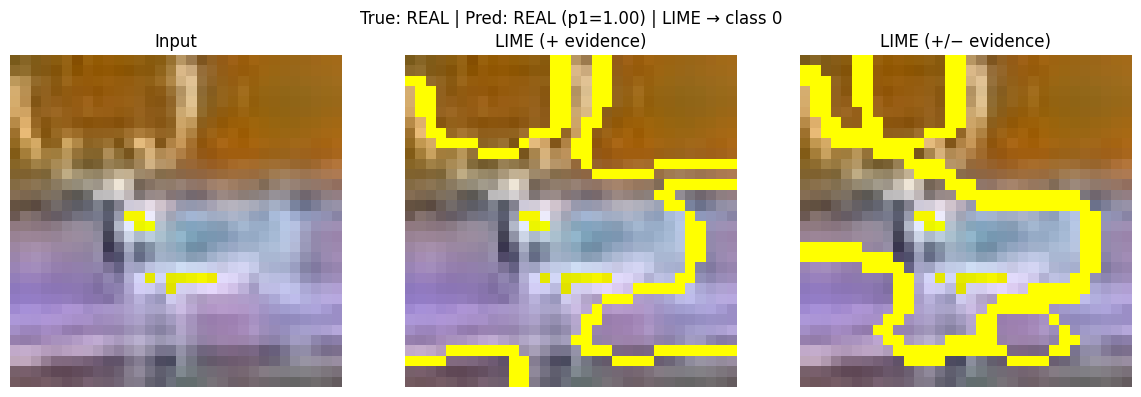

  0%|          | 0/1000 [00:00<?, ?it/s]

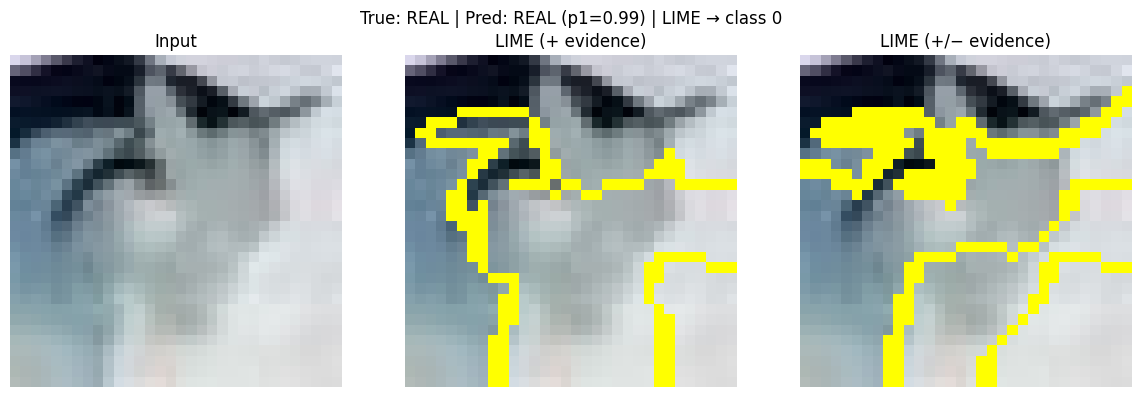

  0%|          | 0/1000 [00:00<?, ?it/s]

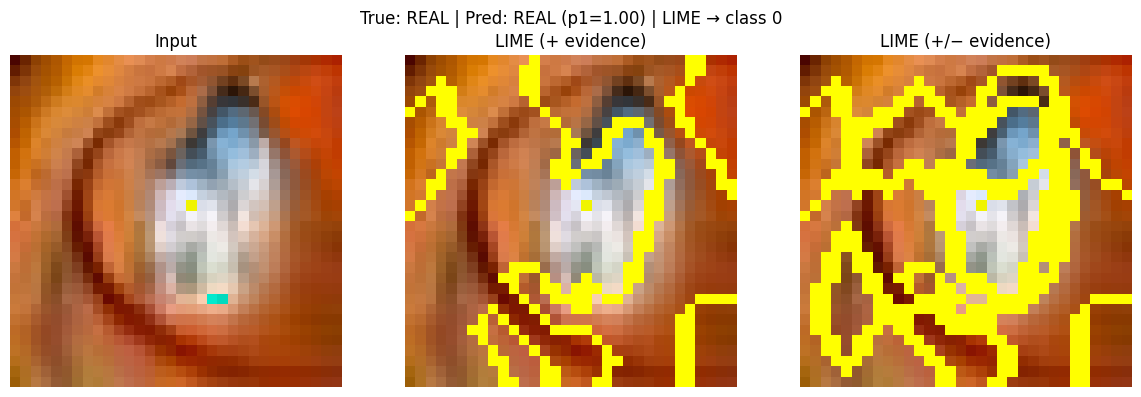

In [ ]:
# If needed:
# !pip install -q lime scikit-image

import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
import tensorflow as tf

# ----------------------------
# 1) Choose which class to explain
# CIFAKE: FAKE=0, REAL=1
TARGET_CLASS = 0   # set to 1 to explain REAL

# ----------------------------
# 2) Prediction wrapper for LIME
def predict_proba_for_lime(imgs_uint8):
    """
    LIME passes uint8 images (N,H,W,C) in [0..255].
    Convert to model's input and return (N,2) probs [P(0), P(1)].
    """
    x = imgs_uint8.astype(np.float32) / 255.0   # adjust if you used different preprocessing
    p1 = model.predict(x, verbose=0).reshape(-1)  # sigmoid -> P(class=1)
    p0 = 1.0 - p1
    return np.stack([p0, p1], axis=1)

# ----------------------------
# 3) Segmentation function tuned for 32x32
def segmentation_fn(img):
    # Fewer superpixels work better on tiny images; tweak if needed
    return slic(img, n_segments=25, compactness=10, sigma=1, start_label=0)

# ----------------------------
# 4) Build explainer
explainer = lime_image.LimeImageExplainer()

# ----------------------------
# 5) Grab a small batch from validation
for images, labels in validation.take(1):
    imgs = images.numpy()                      # assume already [0,1]
    labs = labels.numpy().astype(int)
    imgs_u8 = (imgs * 255).astype(np.uint8)    # LIME expects uint8
    break

# ----------------------------
# 6) Explain first 10 validation images
N = min(10, len(imgs_u8))
for i in range(N):
    img_u8 = imgs_u8[i]
    true_lbl = 'REAL' if labs[i] == 1 else 'FAKE'
    p1 = float(model.predict(imgs[i:i+1], verbose=0).ravel()[0])
    pred_lbl = 'REAL' if p1 > 0.5 else 'FAKE'

    exp = explainer.explain_instance(
        image=img_u8,
        classifier_fn=predict_proba_for_lime,
        top_labels=2,
        hide_color=None,         # keep original pixels outside selected superpixels
        num_samples=1000,        # ↑ for smoother explanations (slower)
        batch_size=64,
        segmentation_fn=segmentation_fn
    )

    # Positive evidence for TARGET_CLASS
    # Returns (overlay_image, mask); we’ll use the mask to draw boundaries on original img
    _, mask_pos = exp.get_image_and_mask(
        label=TARGET_CLASS,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Positive + Negative evidence
    _, mask_all = exp.get_image_and_mask(
        label=TARGET_CLASS,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    # ----------------------------
    # 7) Visualize
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"True: {true_lbl} | Pred: {pred_lbl} (p1={p1:.2f}) | LIME → class {TARGET_CLASS}")

    # Original
    axes[0].imshow(img_u8)
    axes[0].set_title("Input")
    axes[0].axis("off")

    # LIME (+ evidence) — boundaries on original image
    axes[1].imshow(mark_boundaries(img_u8/255.0, mask_pos))
    axes[1].set_title("LIME (+ evidence)")
    axes[1].axis("off")

    # LIME (+/− evidence) — boundaries on original image
    axes[2].imshow(mark_boundaries(img_u8/255.0, mask_all))
    axes[2].set_title("LIME (+/− evidence)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-2870261098.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[0].numpy())


  0%|          | 0/1000 [00:00<?, ?it/s]

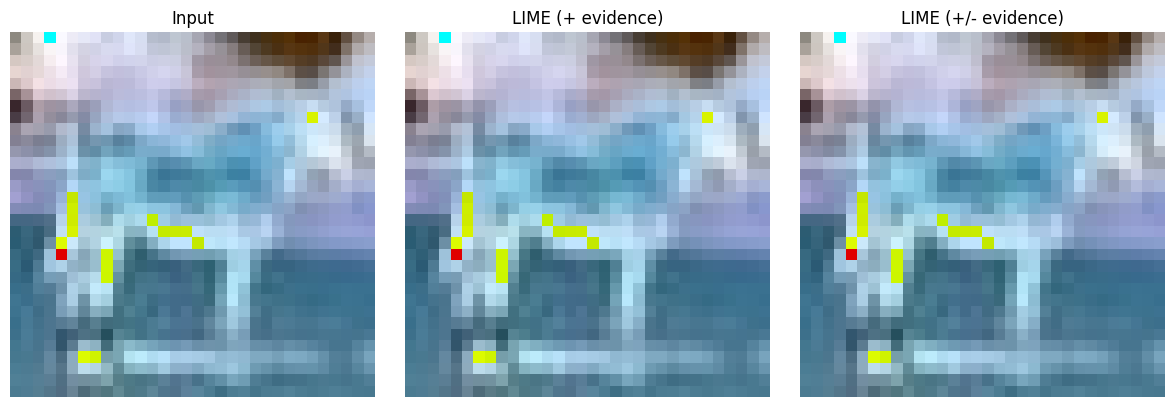

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Reuse prediction wrapper & explainer from before
explainer = lime_image.LimeImageExplainer()

# Example: take first validation image
for images, labels in validation.take(1):
    img = (images[0].numpy() * 255).astype(np.uint8)   # ensure uint8
    true_label = int(labels[0].numpy())
    break

# Explain instance
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_proba_for_lime,
    top_labels=2,
    hide_color=None,
    num_samples=1000
)

# ---- Positive only (class = 0 or 1) ----
lime_img, mask = explanation.get_image_and_mask(
    label=0,                     # target class
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# ---- Positive & negative evidence ----
lime_img_all, mask_all = explanation.get_image_and_mask(
    label=0,
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# ---- Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
axes[0].imshow(img)
axes[0].set_title("Input")
axes[0].axis("off")

# LIME (+ evidence)
axes[1].imshow(mark_boundaries(img/255.0, mask))
axes[1].set_title("LIME (+ evidence)")
axes[1].axis("off")

# LIME (+/- evidence)
axes[2].imshow(mark_boundaries(img/255.0, mask_all))
axes[2].set_title("LIME (+/- evidence)")
axes[2].axis("off")

plt.tight_layout()
plt.show()


/tmp/ipython-input-1973020902.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[0].numpy())


  0%|          | 0/2000 [00:00<?, ?it/s]

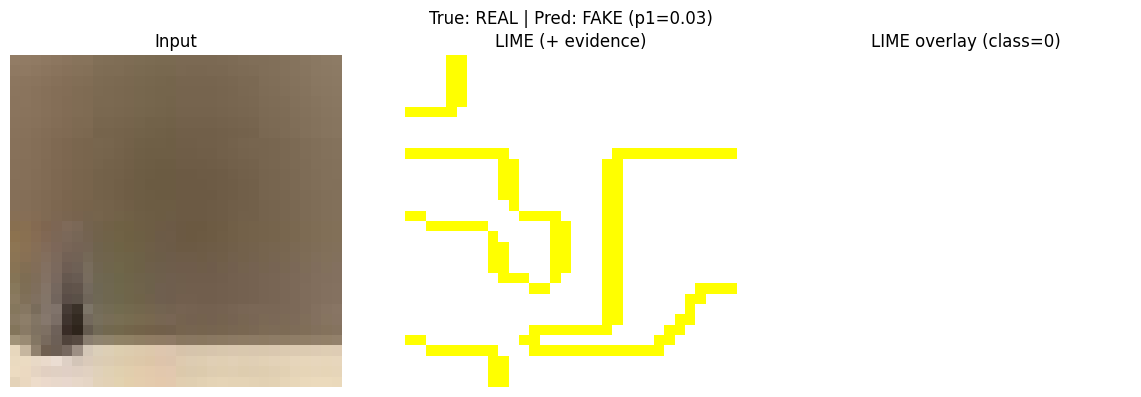

In [ ]:
# !pip install -q lime scikit-image

import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic
from skimage.color import gray2rgb

# --- choose class to explain: predicted (default) or fixed (e.g., FAKE=0 / REAL=1) ---
EXPLAIN_PREDICTED_CLASS = True
TARGET_CLASS = 0  # used only if EXPLAIN_PREDICTED_CLASS=False

# --- model wrapper (binary sigmoid -> 2-class probs) ---
def predict_proba_for_lime(imgs_uint8):
    x = imgs_uint8.astype(np.float32) / 255.0          # adjust if you used different preprocessing
    p1 = model.predict(x, verbose=0).reshape(-1)       # P(class=1)
    p0 = 1.0 - p1
    return np.stack([p0, p1], axis=1)

# --- segmentation tuned for tiny images like 32x32 ---
def segmentation_fn(img):
    # n_segments ~ 20–60 works well for 32x32; tweak if needed
    return slic(img, n_segments=40, compactness=10, sigma=1, start_label=0)

explainer = lime_image.LimeImageExplainer()

# ----- get one validation image (uint8 for LIME) -----
for images, labels in validation.take(1):
    img_f = images[0].numpy()                           # [0,1] float
    if img_f.shape[-1] == 1:                           # safety: make RGB if grayscale
        img_f = gray2rgb(img_f[..., 0])
    img_u8 = (img_f * 255).astype(np.uint8)
    true_label = int(labels[0].numpy())
    break

# ----- decide label to explain -----
p1 = float(model.predict(img_f[None, ...], verbose=0).ravel()[0])
pred_label = 1 if p1 > 0.5 else 0
label_to_explain = pred_label if EXPLAIN_PREDICTED_CLASS else TARGET_CLASS

# ----- run LIME -----
exp = explainer.explain_instance(
    image=img_u8,
    classifier_fn=predict_proba_for_lime,
    top_labels=2,
    hide_color=None,           # keep original pixels
    num_samples=2000,          # ↑ for smoother explanations (slower)
    batch_size=64,
    segmentation_fn=segmentation_fn
)

# ----- build colored overlay from superpixel weights -----
# local_exp[label] gives list of (superpixel_id, weight)
segments = exp.segments
sp_weights = dict(exp.local_exp[label_to_explain])

# normalize weights for alpha
w_vals = np.array(list(sp_weights.values()))
if w_vals.size == 0:
    w_min, w_max = 0.0, 1.0
else:
    w_min, w_max = np.percentile(w_vals, [5, 95])
    if w_max <= w_min: w_max = w_min + 1e-6

overlay = img_f.copy()
alpha_map = np.zeros_like(segments, dtype=np.float32)

# color positive = green, negative = red
pos_color = np.array([0.0, 1.0, 0.0])   # RGB in 0..1
neg_color = np.array([1.0, 0.0, 0.0])

for sp_id, w in sp_weights.items():
    mask = (segments == sp_id)
    # map weight -> alpha (0..0.6)
    a = np.clip((abs(w) - w_min) / (w_max - w_min + 1e-6), 0, 1) * 0.6
    alpha_map[mask] = np.maximum(alpha_map[mask], a)
    color = pos_color if w > 0 else neg_color
    overlay[mask] = (1 - a) * overlay[mask] + a * color

# ----- plots: original, positive-only, full overlay with legend -----
from skimage.segmentation import mark_boundaries

pos_img, pos_mask = exp.get_image_and_mask(
    label=label_to_explain, positive_only=True, num_features=10, hide_rest=False
)
pos_boundaries = mark_boundaries(img_f, pos_mask)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img_u8); axes[0].set_title("Input"); axes[0].axis("off")
axes[1].imshow(pos_boundaries); axes[1].set_title("LIME (+ evidence)"); axes[1].axis("off")
axes[2].imshow(overlay); axes[2].set_title(f"LIME overlay (class={label_to_explain})"); axes[2].axis("off")
plt.suptitle(f"True: {['FAKE','REAL'][true_label]} | Pred: {['FAKE','REAL'][pred_label]} (p1={p1:.2f})")
plt.tight_layout(); plt.show()


**SHAP**

In [ ]:
# !pip install -q shap
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
# grab ~100 background examples (keep small for stability/speed)
bg_list = []
for batch_x, _ in train.take(4):   # 4 * 32(batch) ≈ 128 images
    bg_list.append(batch_x.numpy())
background = np.concatenate(bg_list, axis=0)[:100]    # (100, 32, 32, 3)

# grab a set of images to explain (e.g., 20 from validation)
test_list = []
test_labels = []
for batch_x, batch_y in validation.take(1):
    test_list.append(batch_x.numpy())
    test_labels.append(batch_y.numpy().astype(int))
X_explain = np.concatenate(test_list, axis=0)[:20]     # (20, 32, 32, 3)
y_explain = np.concatenate(test_labels, axis=0)[:20].ravel()


In [ ]:
def predict_p1(x):
    """Return probability of class 1 (REAL). Shape: (N,1)."""
    return model.predict(x, verbose=0)


In [ ]:
try:
    explainer = shap.GradientExplainer(model, background)  # TF2/Keras supported
    # SHAP values for class 1 (REAL); shape: (N, H, W, C)
    shap_values_p1 = explainer.shap_values(X_explain)      # returns array for single-output model
    # ensure it's a numpy array
    if isinstance(shap_values_p1, list):
        shap_values_p1 = shap_values_p1[0]
    print("GradientExplainer OK:", shap_values_p1.shape)
except Exception as e:
    print("GradientExplainer failed, falling back to KernelExplainer:", e)
    # KernelExplainer fallback (slower)
    f = lambda z: predict_p1(z).reshape(-1)                # (N,) for KernelExplainer
    # downsample background further for speed
    background_small = background[:50]
    explainer = shap.KernelExplainer(f, background_small)
    # run on a few samples to keep it quick
    shap_values_p1 = explainer.shap_values(X_explain[:10], nsamples=200)  # (10, H*W*C)
    # reshape back to image
    shap_values_p1 = np.array(shap_values_p1).reshape(-1, *X_explain.shape[1:])


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_90
Received: inputs=['Tensor(shape=(20, 32, 32, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_90
Received: inputs=['Tensor(shape=(50, 32, 32, 3))']
  warnings.warn(msg)


GradientExplainer OK: (20, 32, 32, 3, 1)


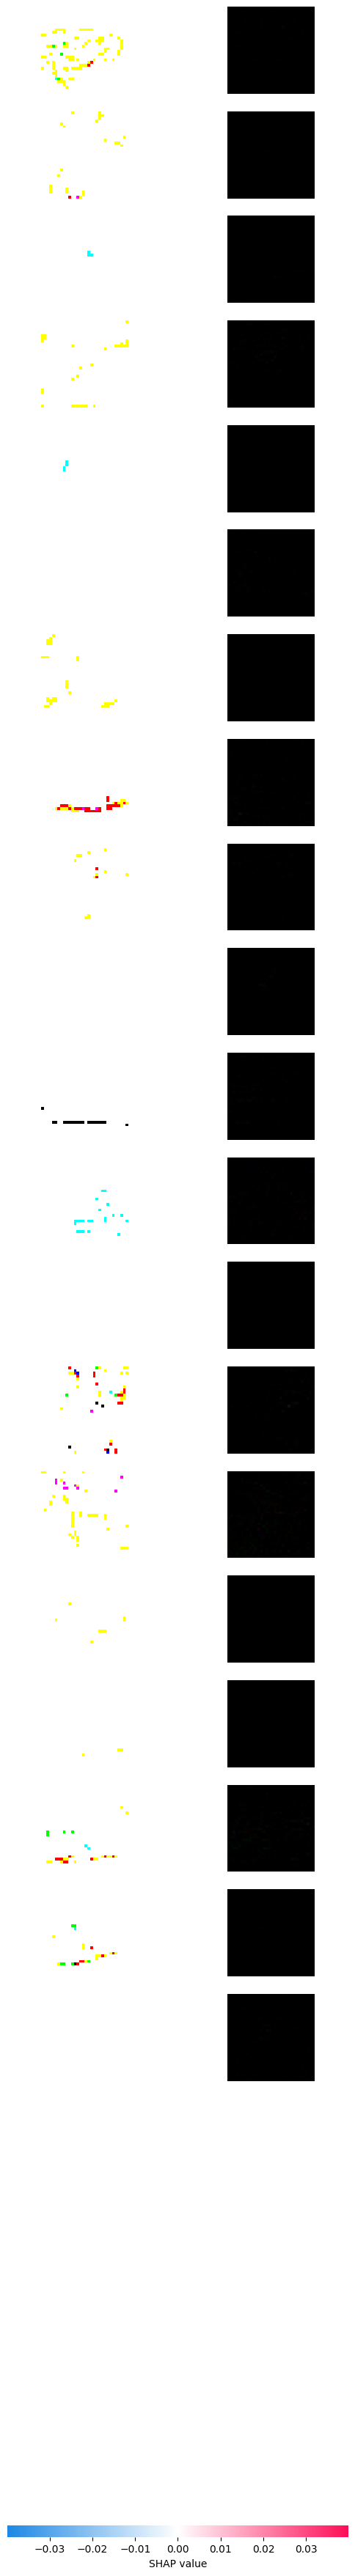

In [ ]:
# SHAP expects images in [0,1]; ensure that’s true for X_explain
X_disp = np.clip(X_explain, 0.0, 1.0)

# Positive values (red) push toward REAL (class 1), negative (blue) push toward FAKE (class 0)
shap.image_plot([shap_values_p1], X_disp, show=True)


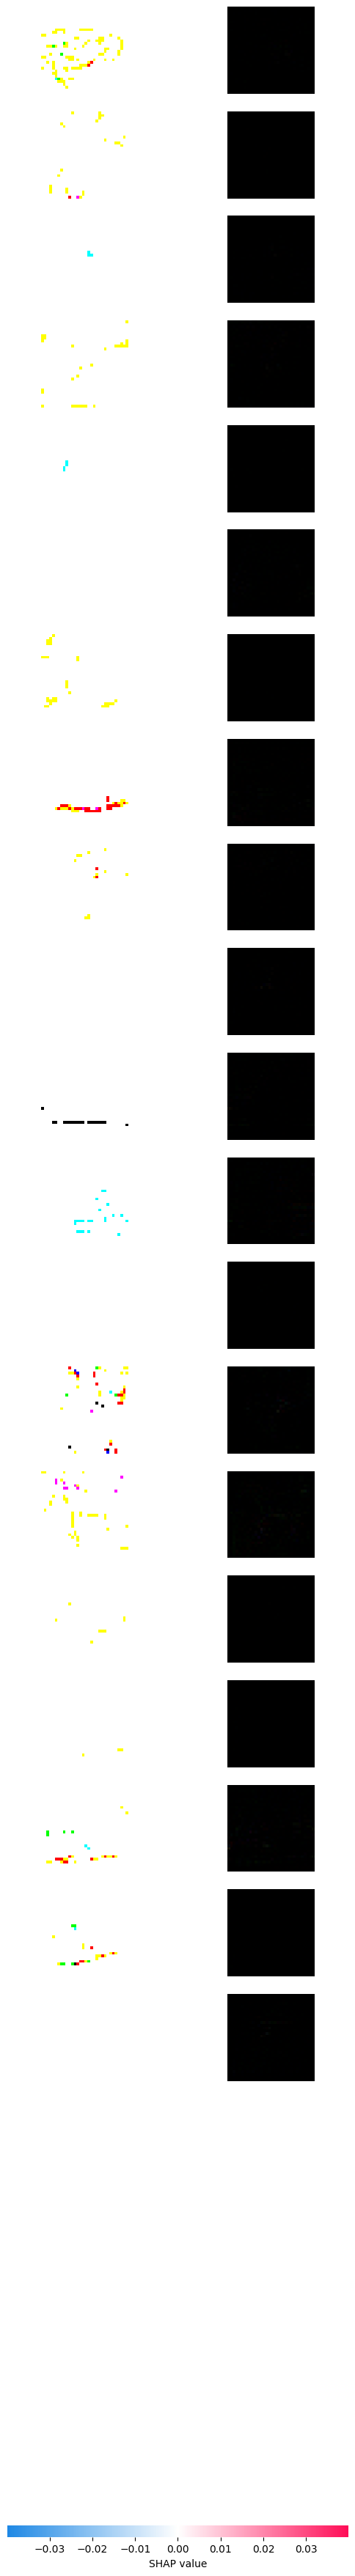

In [ ]:
# Option A: negate to view contributions toward class 0
shap_values_p0 = -shap_values_p1
shap.image_plot([shap_values_p0], X_disp, show=True)

# Option B (alt): build a wrapper for class 0 and recompute
# def predict_p0(x): return 1.0 - predict_p1(x)
# explainer_0 = shap.GradientExplainer(lambda t: predict_p0(t), background)
# shap_values_p0 = explainer_0.shap_values(X_explain)


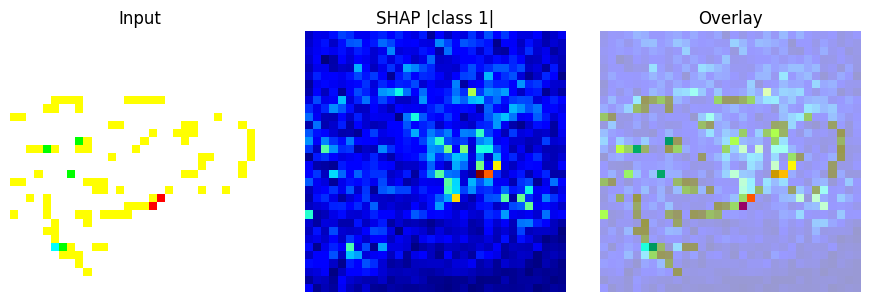

img: (32, 32, 3) sv: (32, 32, 3) sv_map: (32, 32)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf

idx = 0
img = X_disp[idx]          # (H,W,C), values expected in [0,1]
sv  = shap_values_p1[idx]  # SHAP for class 1; shape can vary

# --- ensure image is RGB float in [0,1] ---
img = np.asarray(img, dtype=np.float32)
if img.ndim == 2:
    img = np.stack([img]*3, axis=-1)
elif img.shape[-1] == 1:
    img = np.repeat(img, 3, axis=-1)
img = np.clip(img, 0.0, 1.0)

# --- make SHAP map 2-D: aggregate across channels and squeeze extras ---
sv_arr = np.asarray(sv, dtype=np.float32)
sv_arr = np.squeeze(sv_arr)                  # remove size-1 axes if any

if sv_arr.ndim == 3:
    # (H,W,C) -> (H,W)
    sv_map = np.mean(np.abs(sv_arr), axis=-1)
elif sv_arr.ndim == 2:
    sv_map = np.abs(sv_arr)
else:
    raise ValueError(f"Unexpected SHAP shape after squeeze: {sv_arr.shape}")

# --- if spatial sizes differ, resize shap map to image size ---
H, W = img.shape[:2]
if sv_map.shape != (H, W):
    sv_map = tf.image.resize(sv_map[..., None], (H, W), method='bilinear').numpy()[..., 0]

# --- normalize to [0,1] ---
sv_map = sv_map / (sv_map.max() + 1e-8)

# --- build RGB heatmap and blend ---
heat_rgb = colormaps.get_cmap('jet')(sv_map)[..., :3].astype(np.float32)  # (H,W,3)
alpha = 0.4
overlay = (1 - alpha) * img + alpha * heat_rgb
overlay = np.clip(overlay, 0.0, 1.0)

# --- show ---
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img);       plt.axis('off'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(sv_map, cmap='jet'); plt.axis('off'); plt.title('SHAP |class 1|')
plt.subplot(1,3,3); plt.imshow(overlay);   plt.axis('off'); plt.title('Overlay')
plt.tight_layout(); plt.show()

# (Optional) sanity prints
print('img:', img.shape, 'sv:', np.squeeze(shap_values_p1[idx]).shape, 'sv_map:', sv_map.shape)


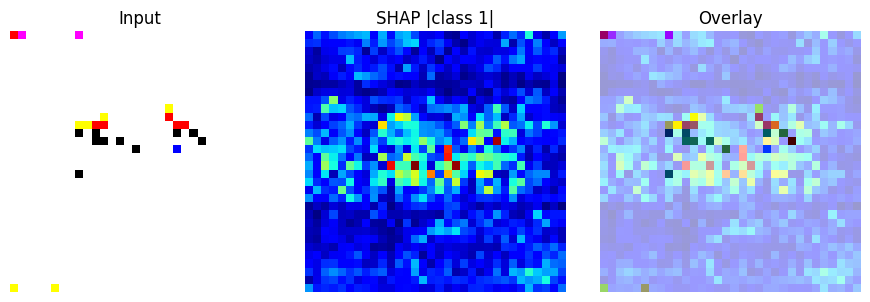

img: (32, 32, 3) sv: (32, 32, 3) sv_map: (32, 32)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf

idx = 0
img = X_disp[idx]          # (H,W,C), values expected in [0,1]
sv  = shap_values_p1[idx]  # SHAP for class 1; shape can vary

# --- ensure image is RGB float in [0,1] ---
img = np.asarray(img, dtype=np.float32)
if img.ndim == 2:
    img = np.stack([img]*3, axis=-1)
elif img.shape[-1] == 1:
    img = np.repeat(img, 3, axis=-1)
img = np.clip(img, 0.0, 1.0)

# --- make SHAP map 2-D: aggregate across channels and squeeze extras ---
sv_arr = np.asarray(sv, dtype=np.float32)
sv_arr = np.squeeze(sv_arr)                  # remove size-1 axes if any

if sv_arr.ndim == 3:
    # (H,W,C) -> (H,W)
    sv_map = np.mean(np.abs(sv_arr), axis=-1)
elif sv_arr.ndim == 2:
    sv_map = np.abs(sv_arr)
else:
    raise ValueError(f"Unexpected SHAP shape after squeeze: {sv_arr.shape}")

# --- if spatial sizes differ, resize shap map to image size ---
H, W = img.shape[:2]
if sv_map.shape != (H, W):
    sv_map = tf.image.resize(sv_map[..., None], (H, W), method='bilinear').numpy()[..., 0]

# --- normalize to [0,1] ---
sv_map = sv_map / (sv_map.max() + 1e-8)

# --- build RGB heatmap and blend ---
heat_rgb = colormaps.get_cmap('jet')(sv_map)[..., :3].astype(np.float32)  # (H,W,3)
alpha = 0.4
overlay = (1 - alpha) * img + alpha * heat_rgb
overlay = np.clip(overlay, 0.0, 1.0)

# --- show ---
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img);       plt.axis('off'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(sv_map, cmap='jet'); plt.axis('off'); plt.title('SHAP |class 1|')
plt.subplot(1,3,3); plt.imshow(overlay);   plt.axis('off'); plt.title('Overlay')
plt.tight_layout(); plt.show()

# (Optional) sanity prints
print('img:', img.shape, 'sv:', np.squeeze(shap_values_p1[idx]).shape, 'sv_map:', sv_map.shape)
